In [1]:
import numpy as np
import pandas as pd
import requests
from scipy.stats import gaussian_kde as gk
import geopandas as gpd
from unicodedata import normalize
import datetime
!pip3 install pandas
!pip3 install lxml

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)


     |████████████████████████████████| 6.9 MB 4.8 MB/s eta 0:00:01     |████████████                    | 2.6 MB 4.8 MB/s eta 0:00:01


In [2]:
# NAME CLEANER

def title_strip(x):
    x_split = x.split(' ')
    char = ['II', 'III', 'IV', '.', 'jr.', '(', ')']
    for c in char:
        for item in x_split:
            if c in item:
                x_split.remove(item)
    return ' '.join(x_split).upper()

def name_flip(x):
    x_split = x.split(' ')
    if ',' in x_split[0]:
        x_split[0] = x_split[0].replace(',', '')
        x_split.append(x_split[0])
        del x_split[0]
    return ' '.join(x_split)

def middle_strip(x):
    x_split = x.split(' ')
    if len(x_split) > 2:
        x_list = [item for index,item in enumerate(x_split) if (index == 0) or (index == len(x_split) - 1)]
        return ' '.join(x_list)
    else:
        return ' '.join(x_split)
    
def name_filter(x):
    x = str(x)
    x = title_strip(x)
    x = name_flip(x)
    x = middle_strip(x)
    x = x.replace(',','')
    return x

def prez_name_cleaner(array):
    name_prez = np.array([])
    for x in array:
        if 'BUSH' in x.upper():
            if 'HERBERT' in x.upper():
                name_prez = np.append(name_prez, 'GEORGE BUSH SR.')
            else:
                name_prez = np.append(name_prez, 'GEORGE BUSH JR.')
        else:
            name_prez = np.append(name_prez, name_filter(x))
    return name_prez


In [3]:
# APT DATE CLEANER

def term_start(x):
    x = str(x)
    x_split = x.split('-')
    term_start = pd.to_datetime(x_split[0], errors='coerce') 
    return term_start

def term_end(x):
    x = str(x)
    x_split = x.split('-')
    if (len(x_split) == 1) or (x_split[1].strip().upper() == 'PRESENT'):
        term_end = pd.to_datetime('2022', errors='coerce')
    else:
        term_end = pd.to_datetime(x_split[1], errors='coerce')
    return term_end
        


In [4]:
#Read in the file containing ideology information judges in the dataset
all_judges = pd.read_csv('all_judges.csv')
fed_judges = all_judges[all_judges['judge_type'] == 'federal'].reset_index(drop=True)
names = np.array([])
for x in all_judges['name']:
    names = np.append(names, name_filter(x))
    
all_judges['name'] = names
all_judges.shape, fed_judges.shape


((25969, 5), (622, 5))

In [5]:
#Functions for reading in and cleaning up the formatting of presidential federal judge nominees scraped from online
#and reformatted into pandas dataframe 
def new_read(df):
    df['Confirmation'] = pd.to_datetime(df['Confirmation'], errors='coerce')
    df = df.drop('First nomination', axis=1)
    df.rename(columns={'Nominee': 'judge_name', 'Court': 'post', 'Confirmation':'term_start'}, inplace=True)
    judge_name = np.array([])
    for x in df['judge_name']:
        judge_name = np.append(judge_name, name_filter(x))
    df['judge_name'] = judge_name
    return df

def mid_read(df):
    df['Confirmation date'] = pd.to_datetime(df['Confirmation date'], errors='coerce')
    df = df.drop(['Nomination withdrawn', 'Senate confirmation vote', 'First nomination date', 'Hearing date'], axis=1)
    df.rename(columns={'Name': 'judge_name', 'Nominated to:': 'post', 'Confirmation date':'term_start'}, inplace=True)
    judge_name = np.array([])
    for x in df['judge_name']:
        judge_name = np.append(judge_name, name_filter(x))
    df['judge_name'] = judge_name
    return df

def old_read(df):
    names = np.array([])
    judge_term_start = np.array([])
    judge_term_end = np.array([])
    for i in range(len(df)):
        name = str(df['First name'].iloc[i] + ' ' + df['Last name'].iloc[i])
        names = np.append(names, name_filter(name))
        judge_term_start = np.append(judge_term_start, term_start(df['Term'].iloc[i]))
        judge_term_end = np.append(judge_term_end, term_end(df['Term'].iloc[i]))

    df['term_start'] = judge_term_start
    df['term_end'] = judge_term_end
    df.insert(0, 'judge_name', names)
    df = df.drop(['First name', 'Last name', 'Status'], axis=1)
    df.rename(columns={'Court': 'post', 'Term':'term'}, inplace=True)
    return df

def super_old_read(df):
    names = np.array([])
    judge_term_start = np.array([])
    judge_term_end = np.array([])
    for i in range(len(df)):
        name = str(df['First name'].iloc[i] + ' ' + df['Last name'].iloc[i])
        names = np.append(names, name_filter(name))
        judge_term_start = np.append(judge_term_start, term_start(df['Term'].iloc[i]))
        judge_term_end = np.append(judge_term_end, term_end(df['Term'].iloc[i]))

    df['term_start'] = judge_term_start
    df['term_end'] = judge_term_end
    df.insert(0, 'judge_name', names)
    df = df.drop(['First name', 'Last name'], axis=1)
    df.rename(columns={'Court': 'post', 'Term':'term'}, inplace=True)
    return df



In [6]:
#Scraping presidential federal judge nominee names from online and converting the data from html tables to 
#pandas dataframes. Cleans these dataframes using the above functions.
#Then combines them all into a comprehensive list of federal judge nominee names since Harrison administration
biden = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Joe_Biden', parse_dates=False)
biden_apt = biden[1]
biden_apt = new_read(biden_apt)

trump = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Donald_Trump', parse_dates=False)
trump_apt = trump[1]
trump_apt = mid_read(trump_apt)

obama = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Barack_Obama', parse_dates=False)
obama_apt = obama[1]
obama_apt = mid_read(obama_apt)

bush = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_George_W._Bush', parse_dates=False)
bush_apt = bush[1]

clinton = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Bill_Clinton', parse_dates=False)
clinton_apt = clinton[1]

hwbush = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_George_H.W._Bush', parse_dates=False)
hwbush_apt = hwbush[1]

reagan = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Ronald_Reagan', parse_dates=False)
reagan_apt = reagan[1]

carter = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Jimmy_Carter', parse_dates=False)
carter_apt = carter[1]

ford = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Gerald_Ford', parse_dates=False)
ford_apt = ford[1]

nixon = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Richard_Nixon', parse_dates=False)
nixon_apt = nixon[1]

johnson = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Lyndon_Johnson', parse_dates=False)
johnson_apt = johnson[1]

kennedy = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_John_F._Kennedy', parse_dates=False)
kennedy_apt = kennedy[1]

eisenhower = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Dwight_Eisenhower', parse_dates=False)
eisenhower_apt = eisenhower[2]
eisenhower_apt = old_read(eisenhower_apt)

truman = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Harry_Truman', parse_dates=False)
truman_apt = truman[2]
truman_apt = old_read(truman_apt)

fdroosevelt = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Franklin_Delano_Roosevelt', parse_dates=False)
fdroosevelt_apt = fdroosevelt[2]
fdroosevelt_apt = old_read(fdroosevelt_apt)

hoover = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Herbert_Hoover', parse_dates=False)
hoover_apt = hoover[2]
hoover_apt = old_read(hoover_apt)

coolidge = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Calvin_Coolidge', parse_dates=False)
coolidge_apt = coolidge[2]
coolidge_apt = old_read(coolidge_apt)

harding = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Warren_Harding', parse_dates=False)
harding_apt = harding[2]
harding_apt = old_read(harding_apt)

wilson = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Woodrow_Wilson', parse_dates=False)
wilson_apt = wilson[2]
wilson_apt = old_read(wilson_apt)

taft = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_William_Howard_Taft', parse_dates=False)
taft_apt = taft[2]
taft_apt = old_read(taft_apt)

troosevelt = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Theodore_Roosevelt', parse_dates=False)
troosevelt_apt = troosevelt[2]
troosevelt_apt = old_read(troosevelt_apt)

mckinley = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_William_McKinley', parse_dates=False)
mckinley_apt = mckinley[2]
mckinley_apt = old_read(mckinley_apt)

cleveland = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Grover_Cleveland', parse_dates=False)
cleveland_apt = cleveland[1]
cleveland_apt = super_old_read(cleveland_apt)

harrison = pd.read_html('https://ballotpedia.org/Federal_judges_nominated_by_Benjamin_Harrison', parse_dates=False)
harrison_apt = harrison[1]
harrison_apt = super_old_read(harrison_apt)

all_apt = pd.concat([bush_apt, clinton_apt, hwbush_apt, reagan_apt, carter_apt, ford_apt, nixon_apt, johnson_apt, kennedy_apt]).reset_index(drop=True)
all_apt = all_apt.drop(['Previous Post:', 'Term:.1', 'Bachelors:', 'Law:'], axis=1)
all_apt.rename(columns={'Judge': 'judge_name', 'Final post:': 'post', 'Term:':'term'}, inplace=True)
judge_term_start = np.array([])
judge_term_end = np.array([])
judge_name = np.array([])
for x in all_apt['term']:
    judge_term_start = np.append(judge_term_start, term_start(x))
    judge_term_end = np.append(judge_term_end, term_end(x))

for x in all_apt['judge_name']:
    judge_name = np.append(judge_name, name_filter(x))
    
all_apt['judge_name'] = judge_name
all_apt['term_start'] = judge_term_start
all_apt['term_end'] = judge_term_end

all_apt = pd.concat([biden_apt, trump_apt, obama_apt, all_apt, eisenhower_apt, truman_apt, fdroosevelt_apt, \
                     hoover_apt, coolidge_apt, harding_apt, wilson_apt,taft_apt, troosevelt_apt, mckinley_apt, \
                    cleveland_apt, harrison_apt]).reset_index(drop=True)
all_apt.shape



(4244, 5)

In [7]:
#Adding an indicator variable to distinguish the partisan leaning of each judge based on their ideology score
all_apt = all_apt.merge(all_judges, how='inner', left_on='judge_name', right_on='name')
all_apt = all_apt.drop(['name','state','judge_type'],axis=1)
party_leaning = np.array([])
for x in all_apt['cf_score']:
    if x > 0:
        party_leaning = np.append(party_leaning, 'R')
    elif x < 0:
        party_leaning = np.append(party_leaning, 'D')
    else:
        party_leaning = np.append(party_leaning, np.nan)
        
end_term_fill = np.array([])
for i in range(len(all_apt)):
    if (all_apt['term'].isnull().iloc[i]) & (all_apt['term_end'].isnull().iloc[i]):
        end_term_fill = np.append(end_term_fill ,pd.to_datetime('2022', errors='coerce'))
    else:
        end_term_fill = np.append(end_term_fill ,all_apt['term_end'].iloc[i])

all_apt['term_end'] = end_term_fill
all_apt['party_leaning'] = party_leaning
all_apt.shape



(2475, 8)

In [8]:
#Scraping and formatting a table of congressional term start and end dates
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_United_States_Congresses', parse_dates=False)
congress_dates = tables[0].drop(['Session', 'Session dates'], axis=1).drop_duplicates().reset_index(drop=True)
congress_dates = congress_dates.append(tables[1].drop(['Session', 'Session dates'], axis=1).drop_duplicates(), ignore_index=True)
congress_dates['Congress ended'][116] = congress_dates['Congress ends'][116]
congress_dates.drop('Congress ends', axis=1, inplace=True)
congress_dates['Congress began'] = pd.to_datetime(congress_dates['Congress began'], errors='coerce')
congress_dates['Congress ended'] = pd.to_datetime(congress_dates['Congress ended'], errors='coerce')
congress_dates.set_index(np.arange(1,118), inplace=True)
congress_dates = congress_dates.reset_index()
congress_dates.shape



(117, 4)

In [9]:
#Scrapes and formats a table of presidential term start and end dates
tables = pd.read_html('https://www.thoughtco.com/presidents-and-vice-presidents-chart-4051729', parse_dates=False)
prez_terms = tables[0]

prez_term_start = np.array([])
prez_term_end = np.array([])
for x in prez_terms['TERM']:
    prez_term_start = np.append(prez_term_start, term_start(x))
    prez_term_end = np.append(prez_term_end, term_end(x))
    
prez_terms['prez_term_start'] = prez_term_start + datetime.timedelta(days=19)
prez_terms['prez_term_end'] = prez_term_end + datetime.timedelta(days=19)
prez_terms['PRESIDENT'] = prez_name_cleaner(prez_terms['PRESIDENT'])
prez_terms.loc[8,['prez_term_end']] = pd.to_datetime('20/1/1841', errors='coerce', dayfirst=True)
prez_terms.loc[45,['prez_term_end']] = pd.to_datetime('20/1/2025', errors='coerce', dayfirst=True)



In [10]:
#Goes through each congress and calculates Senate majority party, median Senate ideological score, if the senate
#had two president preside over it, the median ideological score of Senate Democrats and Republicans, 
#the standard deviation of the ideological scores of Senate Democrats and Republicans, the Senate polarization 
#score, and the start and end dates of the congressional terms
nominate_scores = pd.read_csv('HSall_members.csv')
for i in range (len(nominate_scores)):
    if nominate_scores['party_code'].iloc[i] == 100:
        nominate_scores['party_code'].iloc[i] = 'D'
    elif nominate_scores['party_code'].iloc[i] == 200:
        nominate_scores['party_code'].iloc[i] = 'R'
base_prez_df = nominate_scores[nominate_scores['chamber'] == 'President'].reset_index(drop=True)
senate_stats = pd.DataFrame()
senate_stats['congress'] = base_prez_df['congress']
senate_stats['prez_name'] = base_prez_df['bioname']
senate_stats['prez_party'] = base_prez_df['party_code']
senate_stats['prez_score'] = base_prez_df['nominate_dim1']

senate_party = np.array([])
senate_median = np.array([])
two_prez_senate = np.array([])
dem_median = np.array([])
rep_median = np.array([])
dem_std = np.array([])
rep_std = np.array([])
polarization_score = np.array([])
congress_term_start = []
congress_term_end = []

for i in range(len(senate_stats)):
    run_data = nominate_scores[(nominate_scores['congress'] == senate_stats['congress'][i]) & (nominate_scores['chamber'] == 'Senate')]
    run_data.sort_values(by=['nominate_dim1'], inplace = True)
    run_data.reset_index(drop = True, inplace = True)
    dems = run_data[run_data['party_code'] == 'D']['nominate_dim1']
    dems = dems[~np.isnan(dems)]
    reps = run_data[run_data['party_code'] == 'R']['nominate_dim1']
    reps = reps[~np.isnan(reps)]
    dem_midp = np.median(dems)
    dem_median = np.append(dem_median, dem_midp)
    rep_midp = np.median(reps)
    rep_median = np.append(rep_median, rep_midp)
    dem_sd = np.std(dems)
    dem_std = np.append(dem_std, dem_sd)
    rep_sd = np.std(reps)
    rep_std = np.append(rep_std, rep_sd)
    numerator = rep_median[i] - dem_median[i]
    denominator = np.mean([rep_std[i], dem_std[i]])
    p_s = numerator / denominator
    polarization_score = np.append(polarization_score, p_s)
    time_data = congress_dates[congress_dates['index'] == senate_stats['congress'][i]]
    start = time_data['Congress began'].values[0]
    congress_term_start.append(start)
    end = time_data['Congress ended'].values[0]
    congress_term_end.append(end)
    if senate_stats['prez_score'][i] < 0:
        senate_point = run_data['nominate_dim1'].iloc[np.quantile(np.arange(0, len(run_data)+1), 0.5, interpolation='higher')]
        senate_median = np.append(senate_median, senate_point)
        if senate_point < 0:
            senate_party = np.append(senate_party, 'D')
        elif senate_point > 0:
            senate_party = np.append(senate_party, 'R')
        else:
            senate_party = np.append(senate_party, np.nan)
    elif senate_stats['prez_score'][i] > 0:
        senate_point = run_data['nominate_dim1'].iloc[np.quantile(np.arange(0, len(run_data)+1), 0.5, interpolation='lower')]
        senate_median = np.append(senate_median, senate_point)
        if senate_point < 0:
            senate_party = np.append(senate_party, 'D')
        elif senate_point > 0:
            senate_party = np.append(senate_party, 'R')
        else:
            senate_party = np.append(senate_party, np.nan)
    else:
        senate_median = np.append(senate_median, np.nan)
        senate_party = np.append(senate_party, np.nan)    

congress_term_start = pd.Series(congress_term_start).values
congress_term_end = pd.Series(congress_term_end).values

senate_stats['senate_party'] = senate_party
senate_stats['senate_median_voter'] = senate_median
senate_stats['dem_median'] = dem_median
senate_stats['rep_median'] = rep_median
senate_stats['dem_std'] = dem_std
senate_stats['rep_std'] = rep_std
senate_stats['polarization_score'] = polarization_score
senate_stats['term_start'] = congress_term_start
senate_stats['term_end'] = congress_term_end
senate_stats['prez_name'] = prez_name_cleaner(senate_stats['prez_name'])

senate_stats = senate_stats.merge(prez_terms, how='inner', left_on='prez_name', right_on='PRESIDENT').drop(['PRESIDENT', 'VICE-PRESIDENT','POLITICAL PARTY','TERM'], axis=1).sort_values(by=['congress'])
senate_stats_for_plot = senate_stats.drop_duplicates(subset=['congress']).drop(['prez_name', 'prez_party', 'prez_score', 'prez_term_start', 'prez_term_end'], axis=1)



/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-10-4852233af1b1>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount

In [11]:
#creates a separate dataframe containing just the polarization scores, Democratic and Republican leaning judge median 
#ideology scores, and the standard deviation of Democratic and Republican leaning judges for all the judges actively
#serving during that congressional term
judge_dem_median = np.array([])
judge_rep_median = np.array([])
judge_dem_std = np.array([])
judge_rep_std = np.array([])
judge_polarization_score = np.array([])

for c in senate_stats_for_plot['congress']:
    x = senate_stats_for_plot[senate_stats_for_plot['congress'] == c]['term_start'].values[0]
    y = senate_stats_for_plot[senate_stats_for_plot['congress'] == c]['term_end'].values[0]
    run_data = all_apt[(all_apt['term_start'].values <= y) & (x < all_apt['term_end'].values)]
    run_data.sort_values(by=['cf_score'], inplace = True)
    run_data.reset_index(drop = True, inplace = True)
    dems = run_data[run_data['party_leaning'] == 'D']['cf_score']
    dems = dems[~np.isnan(dems)]
    dem_midp = np.median(dems)
    judge_dem_median = np.append(judge_dem_median, dem_midp)
    reps = run_data[run_data['party_leaning'] == 'R']['cf_score']
    reps = reps[~np.isnan(reps)]
    rep_midp = np.median(reps)
    judge_rep_median = np.append(judge_rep_median, rep_midp)
    judge_dem_std = np.append(judge_dem_std, np.std(dems))
    judge_rep_std = np.append(judge_rep_std, np.std(reps))
    numerator = rep_midp - dem_midp
    denominator = np.mean([np.std(dems), np.std(reps)])
    p_s = numerator / denominator
    judge_polarization_score = np.append(judge_polarization_score, p_s)
    
senate_stats_for_plot['judge_polarization_score'] = judge_polarization_score
senate_stats_for_plot['judge_dem_median'] = judge_dem_median
senate_stats_for_plot['judge_rep_median'] = judge_rep_median
senate_stats_for_plot['judge_dem_std'] = judge_dem_std
senate_stats_for_plot['judge_rep_std'] = judge_rep_std



<ipython-input-11-d97a7ce73b8b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-11-d97a7ce73b8b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)
/opt/conda/lib/python3.8/site-p

In [12]:
#calculates same stats as block above but just for the federal judges appointed during that congressional term
apt_dem_median = np.array([])
apt_rep_median = np.array([])
apt_dem_std = np.array([])
apt_rep_std = np.array([])
apt_polarization_score = np.array([])

for c in senate_stats_for_plot['congress']:
    x = senate_stats_for_plot[senate_stats_for_plot['congress'] == c]['term_start'].values[0]
    y = senate_stats_for_plot[senate_stats_for_plot['congress'] == c]['term_end'].values[0]
    run_data = all_apt[(all_apt['term_start'].values >= x) & (y >= all_apt['term_start'].values)]
    run_data.sort_values(by=['cf_score'], inplace = True)
    run_data.reset_index(drop = True, inplace = True)
    
    dems = run_data[run_data['party_leaning'] == 'D']['cf_score']
    dems = dems[~np.isnan(dems)]
    apt_dem_midp = np.median(dems)
    apt_dem_median = np.append(apt_dem_median, apt_dem_midp)
    
    reps = run_data[run_data['party_leaning'] == 'R']['cf_score']
    reps = reps[~np.isnan(reps)]
    apt_rep_midp = np.median(reps)
    apt_rep_median = np.append(apt_rep_median, apt_rep_midp)
    
    apt_dem_std = np.append(apt_dem_std, np.std(dems))
    apt_rep_std = np.append(apt_rep_std, np.std(reps))
    numerator = apt_rep_midp - apt_dem_midp
    denominator = np.mean([np.std(dems), np.std(reps)])
    p_s = numerator / denominator
    apt_polarization_score = np.append(apt_polarization_score, p_s)
    
senate_stats_for_plot['apt_polarization_score'] = apt_polarization_score
senate_stats_for_plot['apt_dem_median'] = apt_dem_median
senate_stats_for_plot['apt_rep_median'] = apt_rep_median
senate_stats_for_plot['apt_dem_std'] = apt_dem_std
senate_stats_for_plot['apt_rep_std'] = apt_rep_std



<ipython-input-12-749c7cb0d856>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-12-749c7cb0d856>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)
/opt/conda/lib/python3.8/site-p

In [13]:
#Calculates the proportion of Democratic and Republican leaning actively serving federal judges 
#for each congressional term
prop_dem = np.array([])
prop_rep = np.array([])
for c in senate_stats_for_plot['congress']:
    x = senate_stats_for_plot[senate_stats_for_plot['congress'] == c]['term_start'].values[0]
    y = senate_stats_for_plot[senate_stats_for_plot['congress'] == c]['term_end'].values[0]
    run_data = all_apt[(all_apt['term_start'].values <= y) & (x < all_apt['term_end'].values)]
    run_data.sort_values(by=['cf_score'], inplace = True)
    run_data.reset_index(drop = True, inplace = True)
    dems = run_data[run_data['party_leaning'] == 'D']['cf_score']
    dems = dems[~np.isnan(dems)]
    dem_count = len(dems)
    reps = run_data[run_data['party_leaning'] == 'R']['cf_score']
    reps = reps[~np.isnan(reps)]
    rep_count = len(reps)
    total_count = dem_count + rep_count
    if total_count == 0:
        prop_dem = np.append(prop_dem, np.nan)
        prop_rep = np.append(prop_rep, np.nan)
    else:
        dem_prop = dem_count / total_count
        rep_prop = rep_count / total_count
        prop_dem = np.append(prop_dem, dem_prop)
        prop_rep = np.append(prop_rep, rep_prop)

senate_stats_for_plot['prop_dem'] = prop_dem
senate_stats_for_plot['prop_rep'] = prop_rep


<ipython-input-13-bb3789dccd15>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)
<ipython-input-13-bb3789dccd15>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)
<ipython-input-13-bb3789dccd15>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)
<ipython-input-13-bb3789dccd15>:7:

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


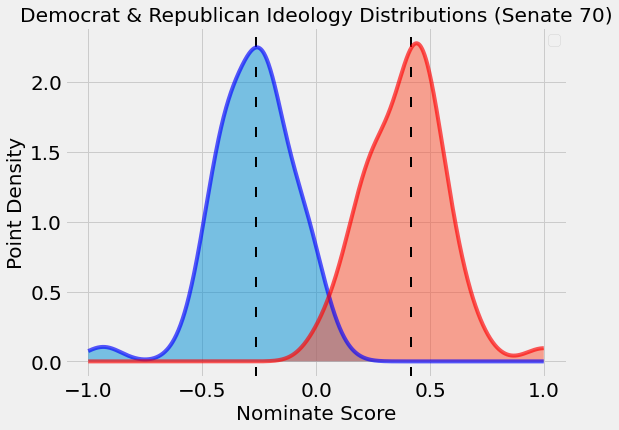

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


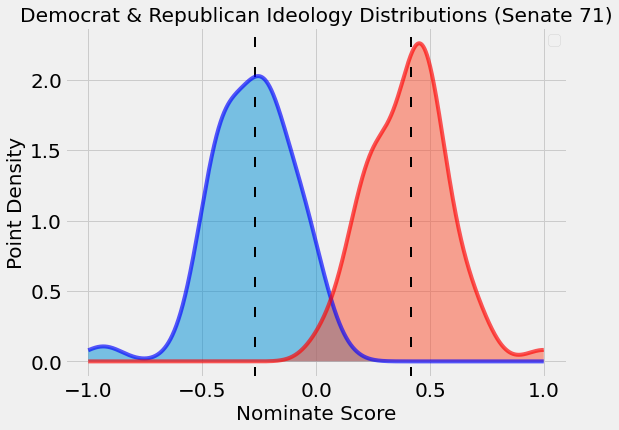

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


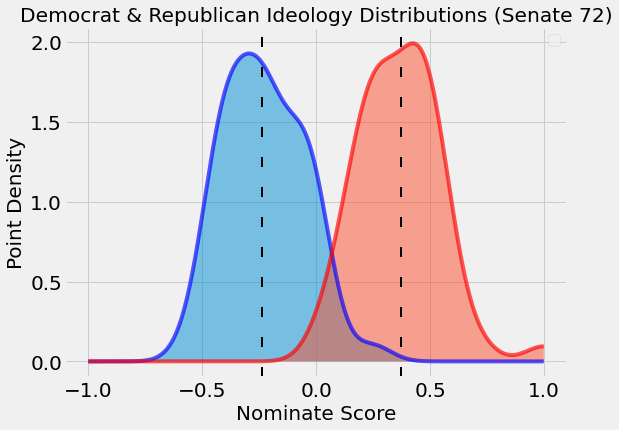

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


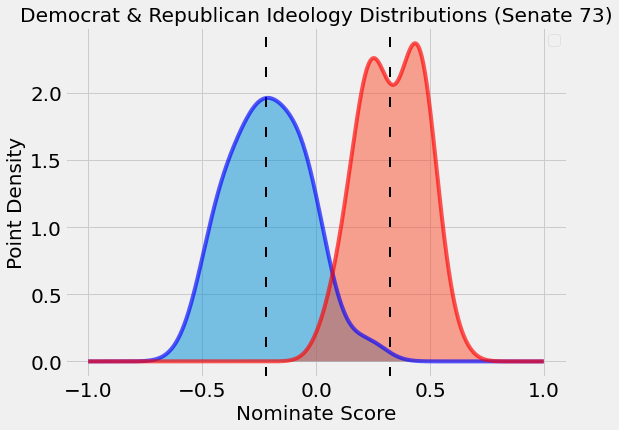

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


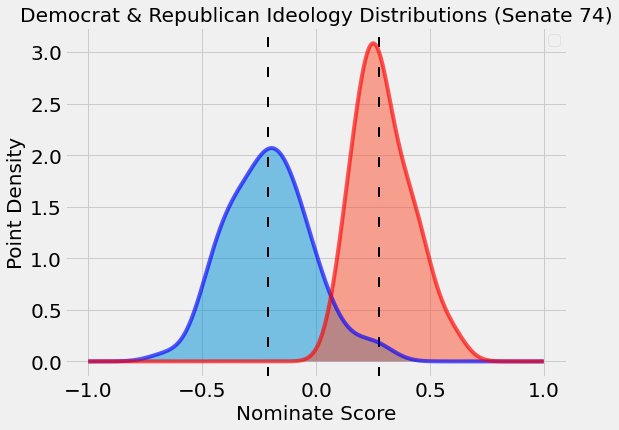

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


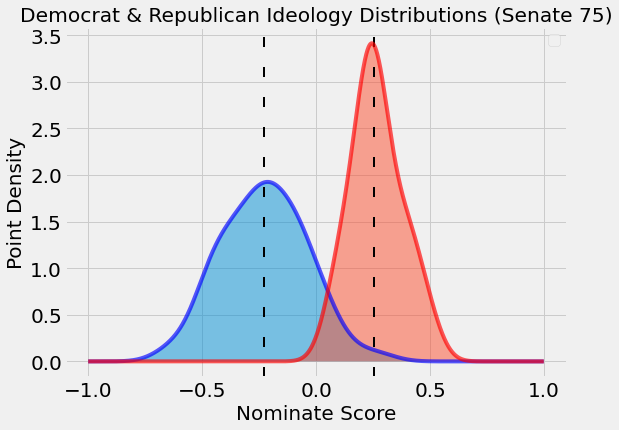

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


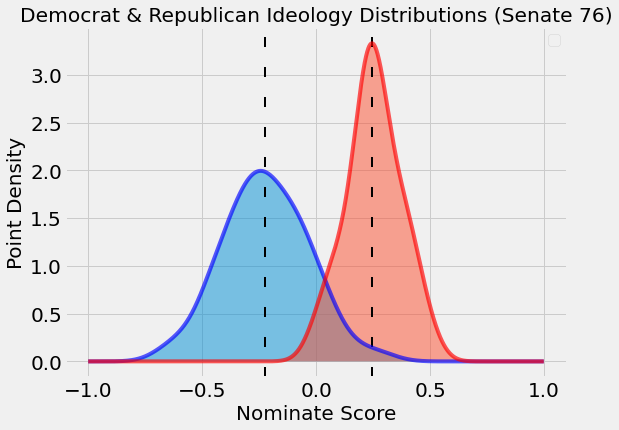

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


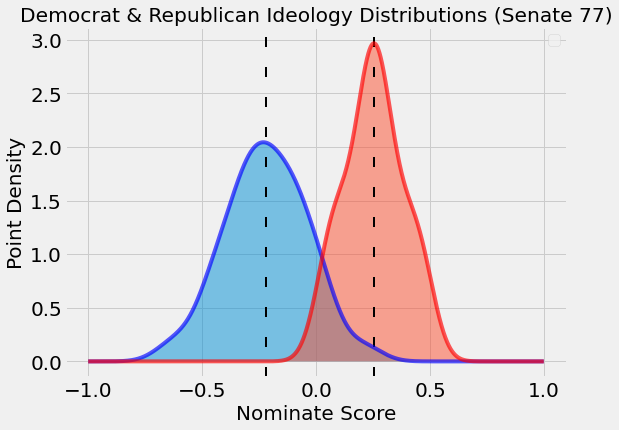

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


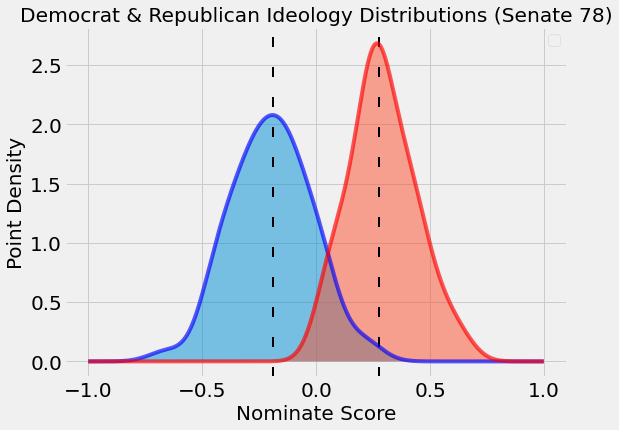

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


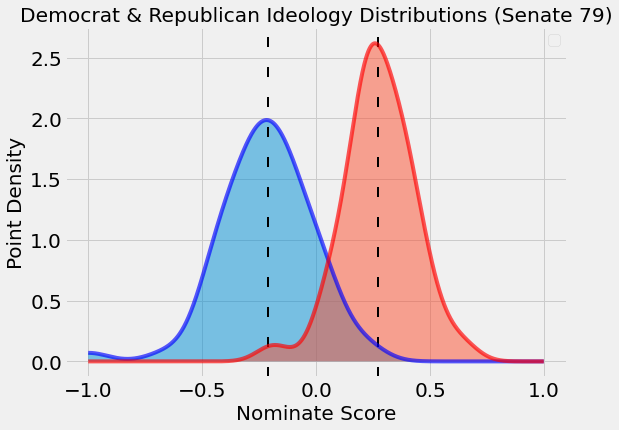

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


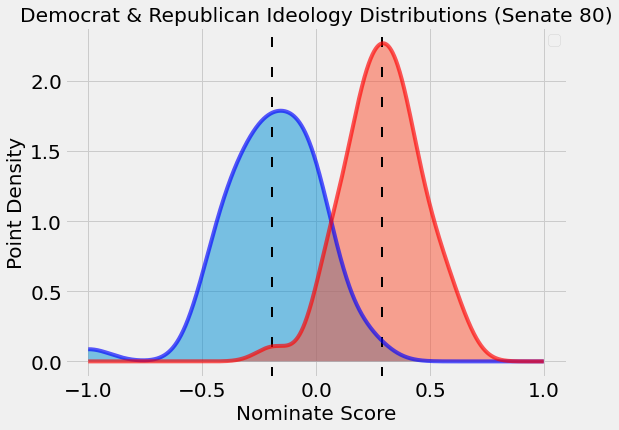

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


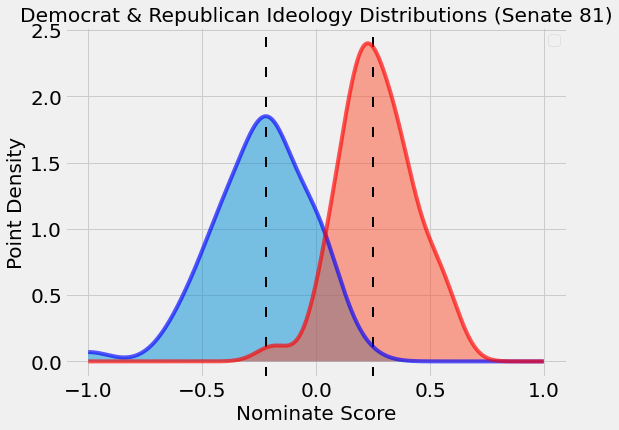

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


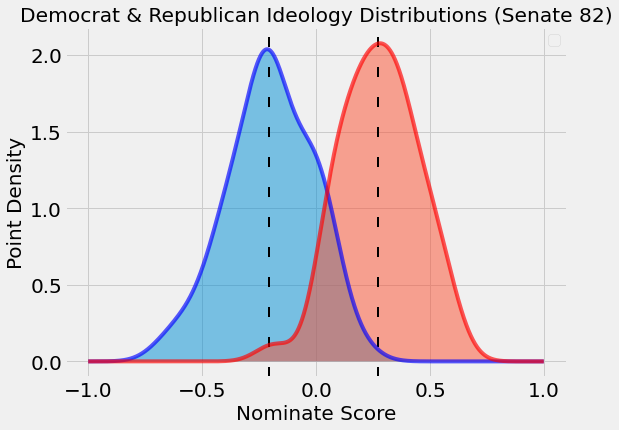

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


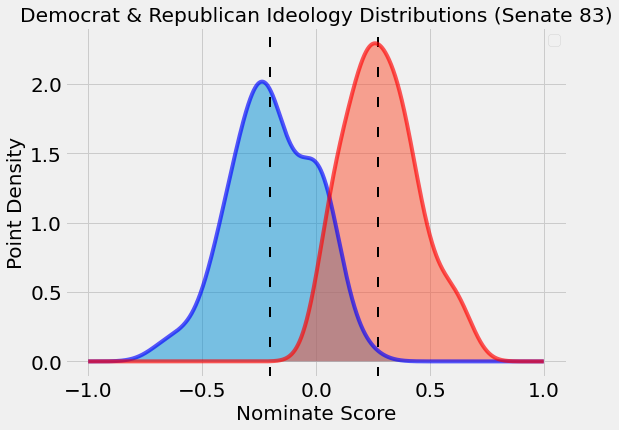

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


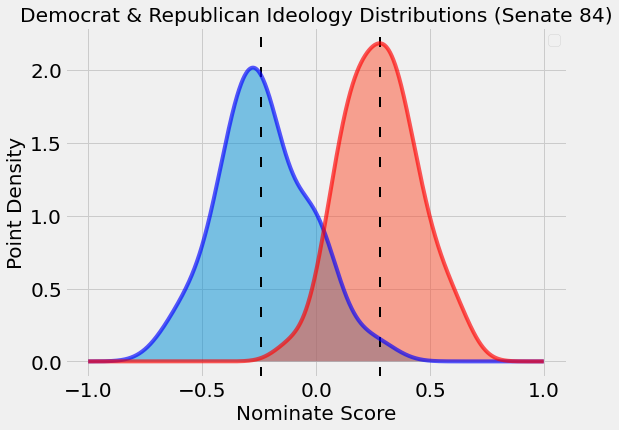

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


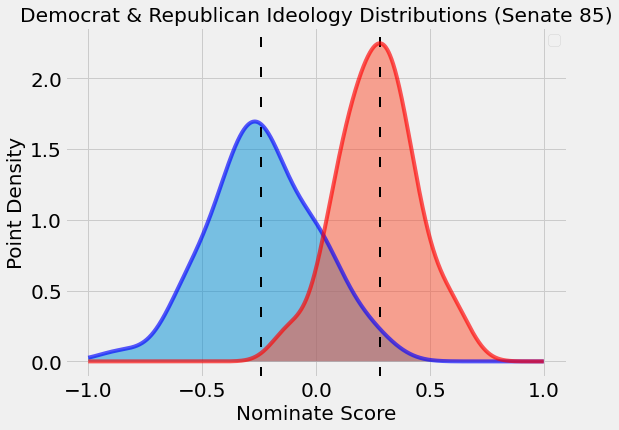

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


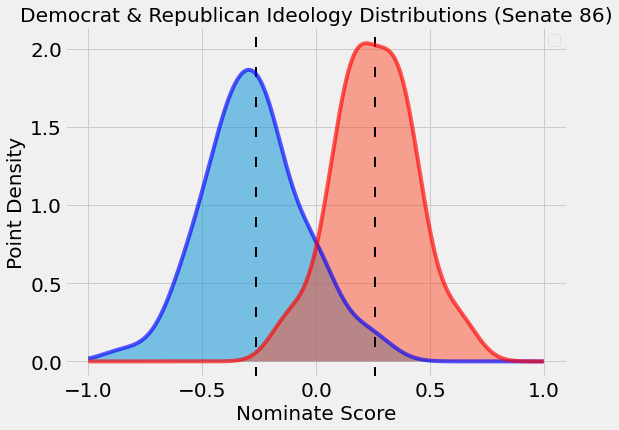

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


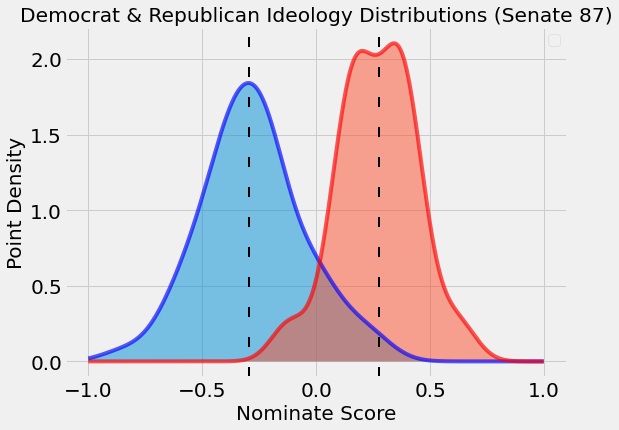

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


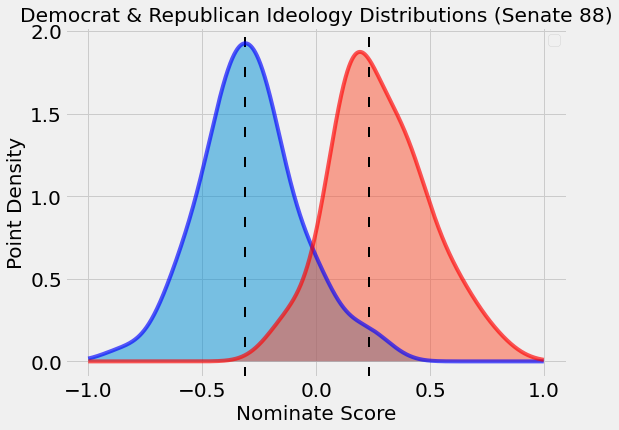

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


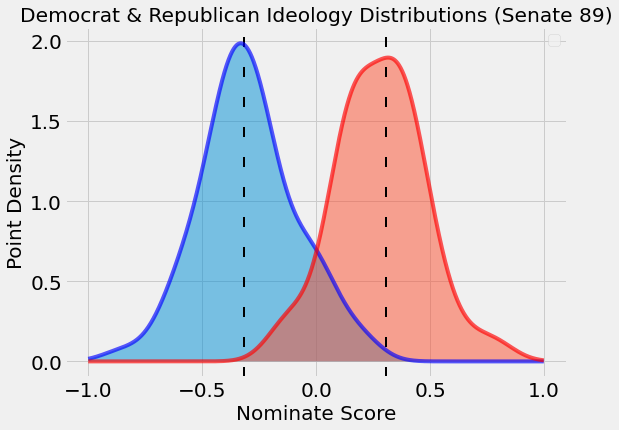

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


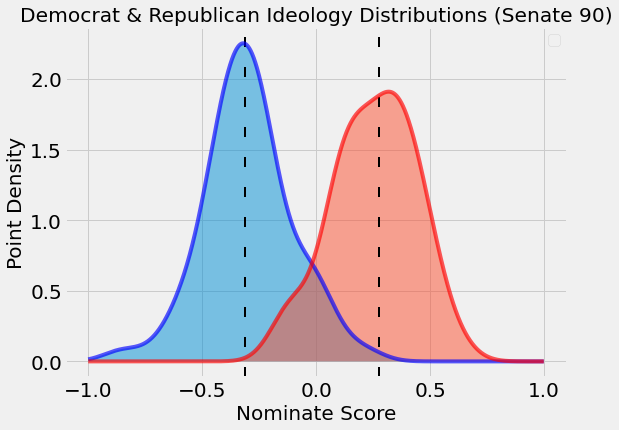

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


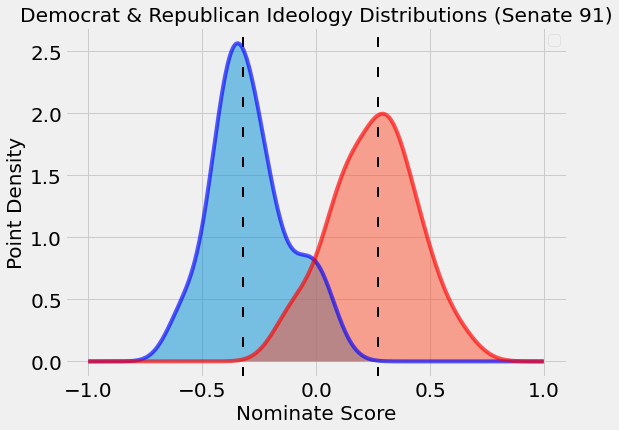

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


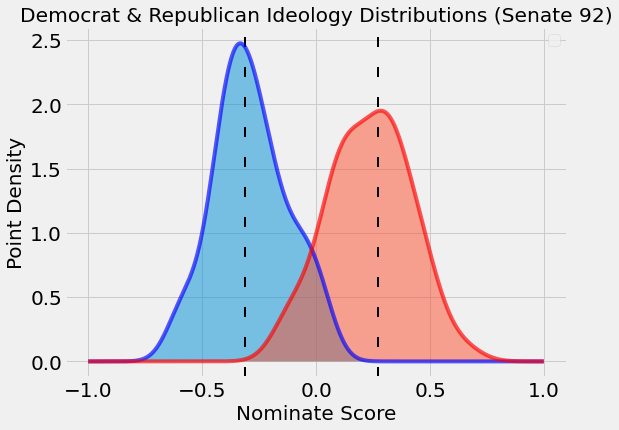

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


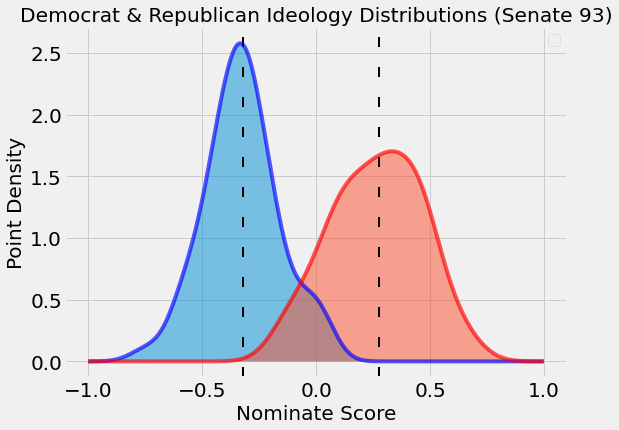

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


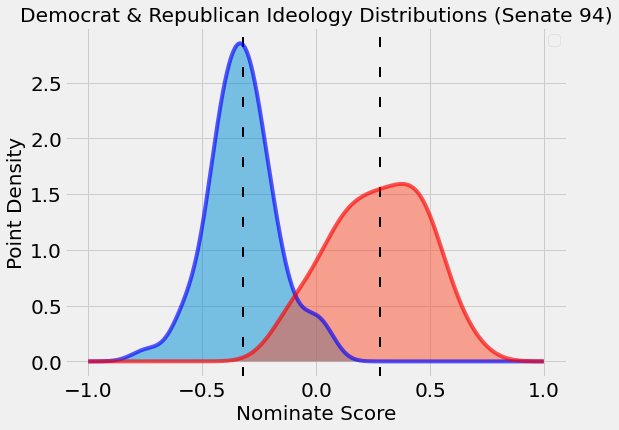

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


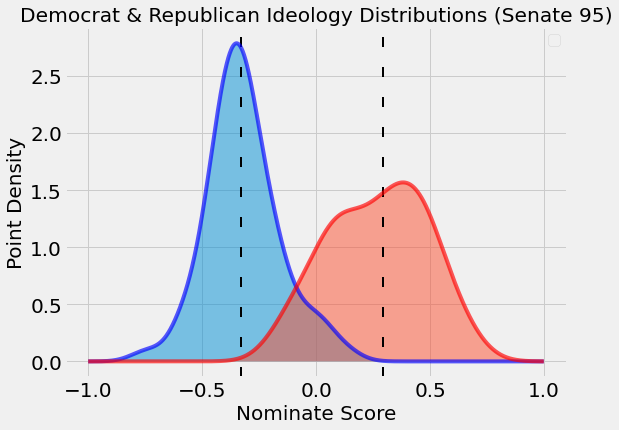

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


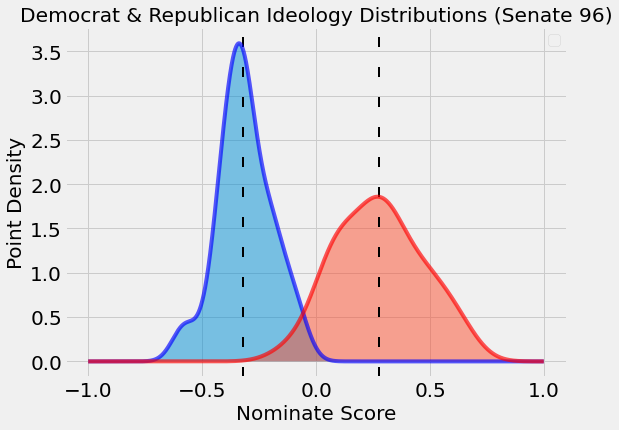

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


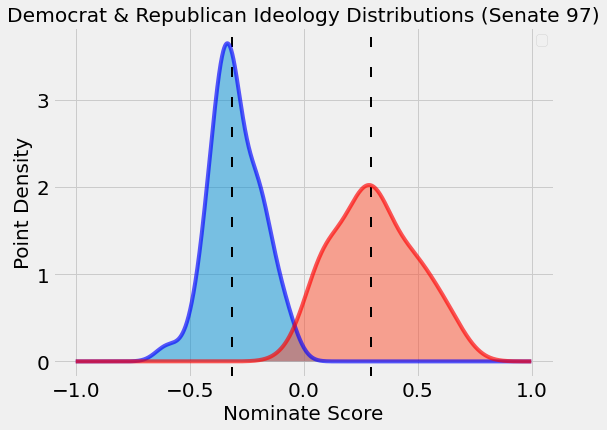

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


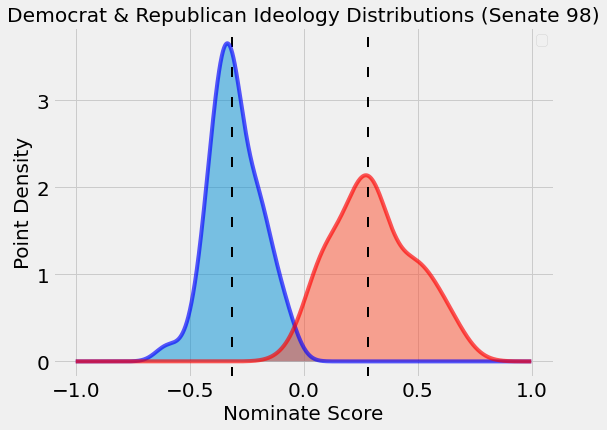

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


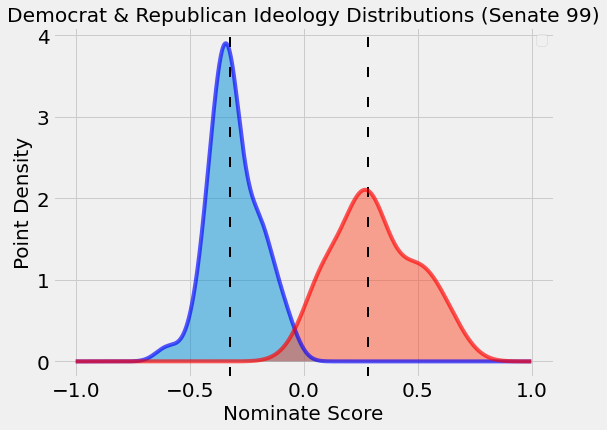

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


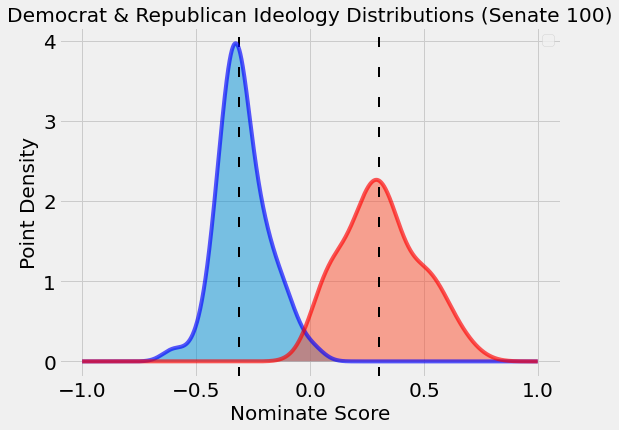

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


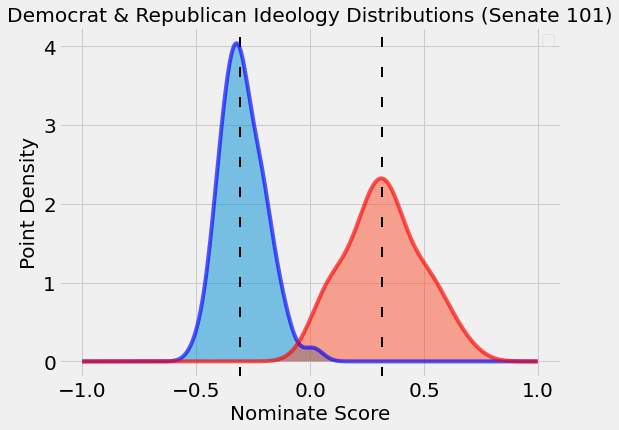

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


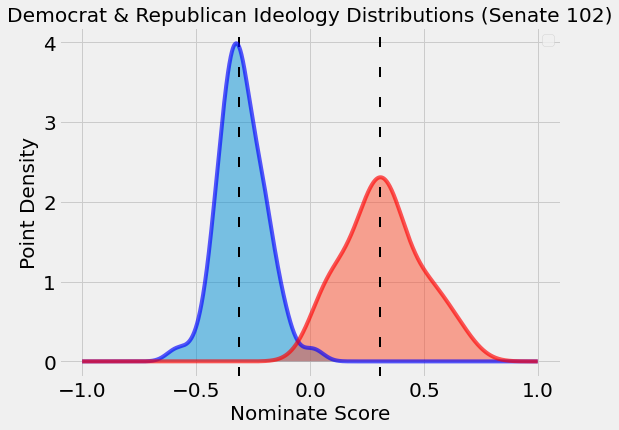

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


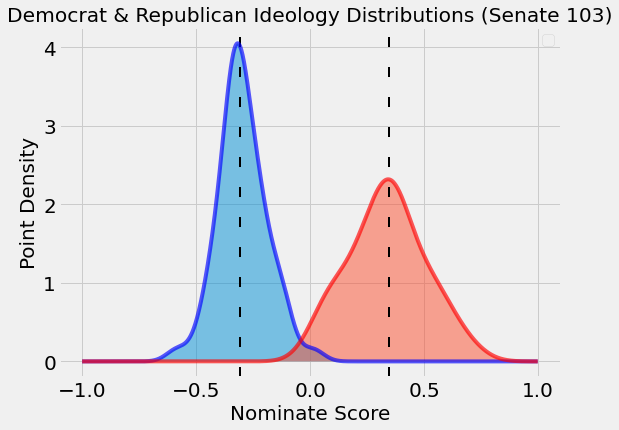

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


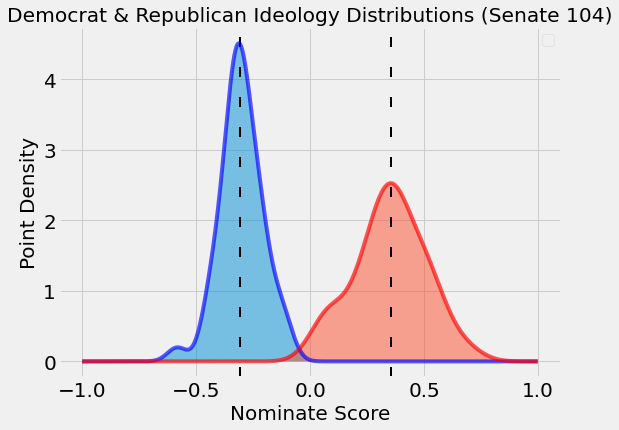

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


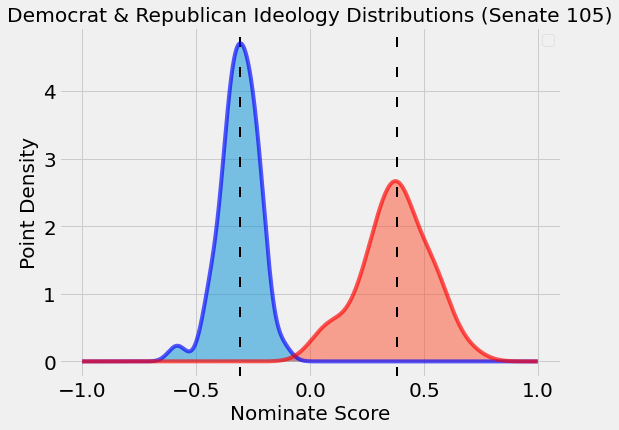

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


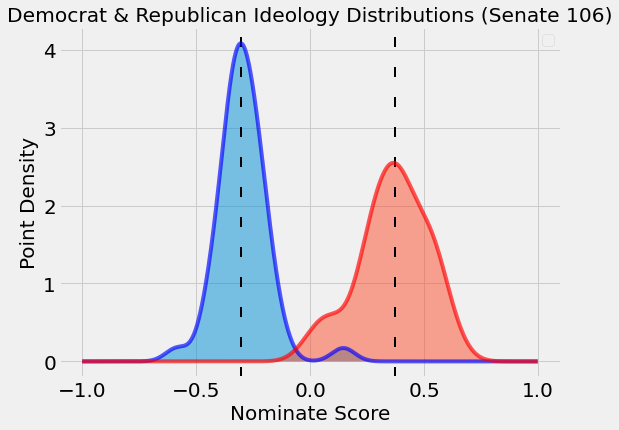

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


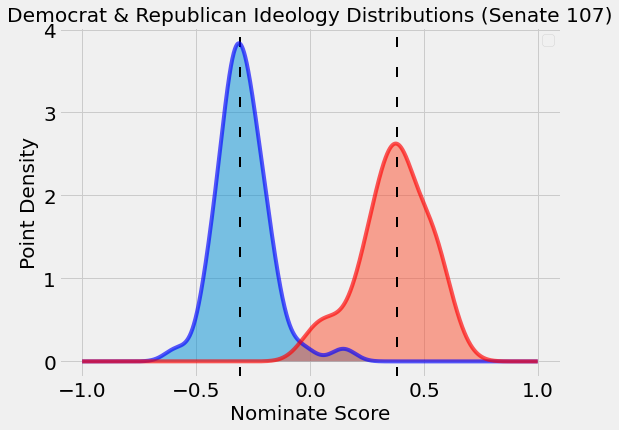

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


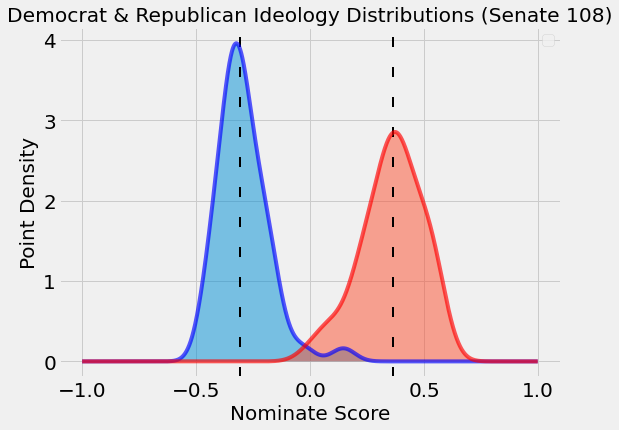

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


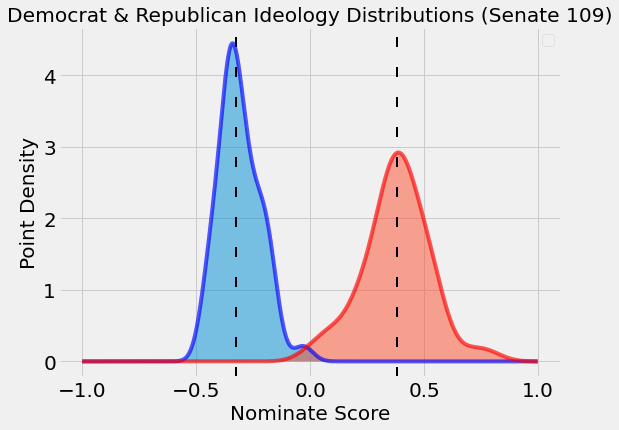

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


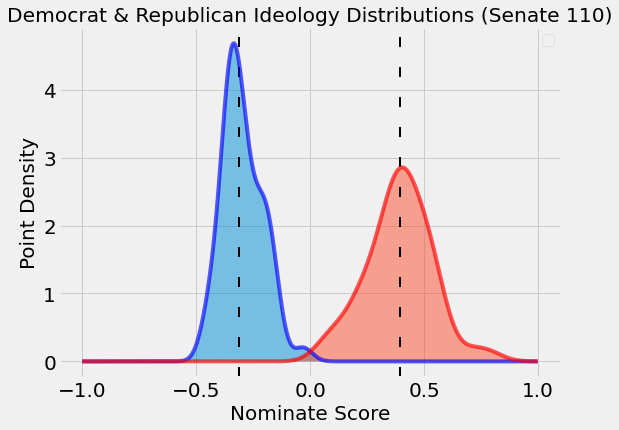

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


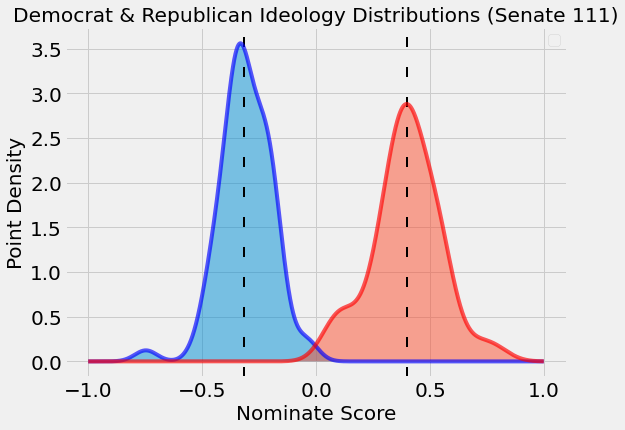

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


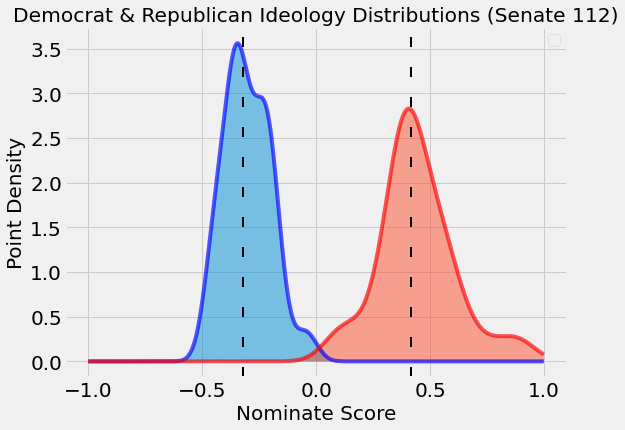

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


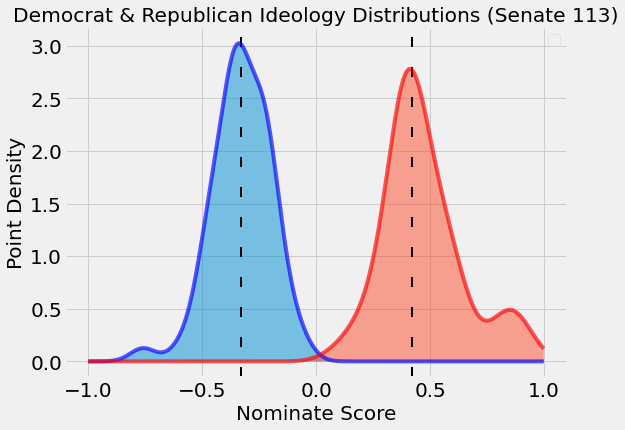

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


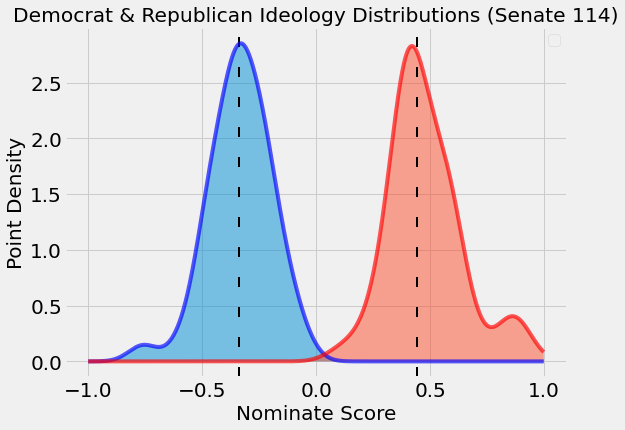

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


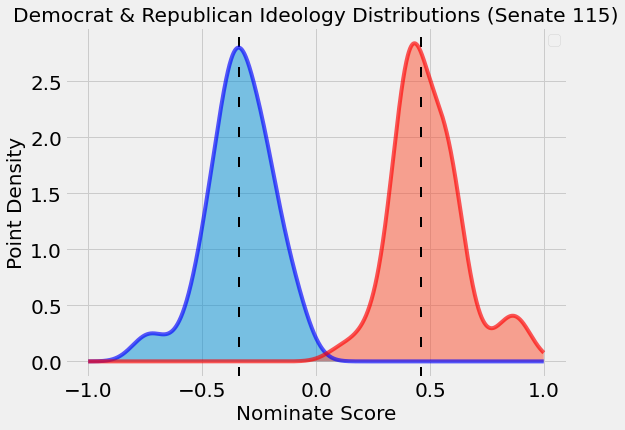

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


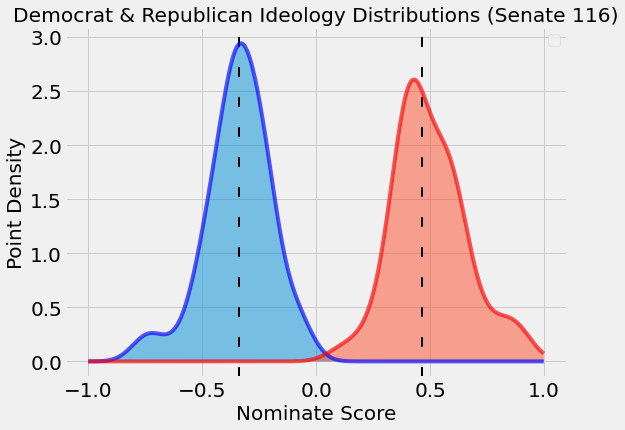

<ipython-input-92-a0e8a9bb8cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


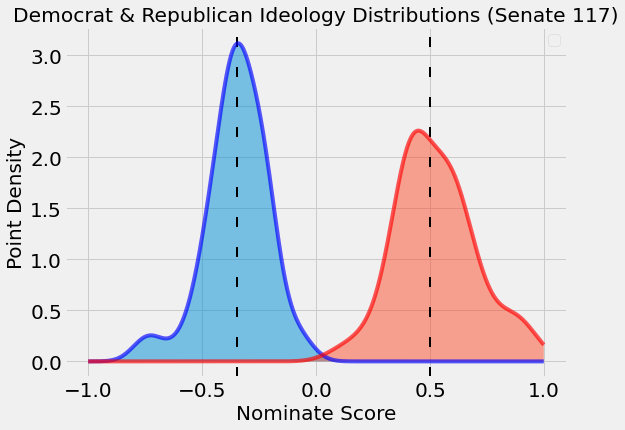

In [92]:
#Generate density curves for the ideological scores of Democrats and Republicans by Senate term
for i in range(70,118):
    run_data = nominate_scores[(nominate_scores['congress'] == i) & (nominate_scores['chamber'] == 'Senate')]
    run_data.sort_values(by=['nominate_dim1'], inplace = True)
    run_data.reset_index(drop = True, inplace = True)
    dems = run_data[run_data['party_code'] == 'D']['nominate_dim1']
    dems = dems[~np.isnan(dems)]
    dem_midp = np.median(dems)
    reps = run_data[run_data['party_code'] == 'R']['nominate_dim1']
    reps = reps[~np.isnan(reps)]
    rep_midp = np.median(reps)
    dem_density = gk(dems)
    rep_density = gk(reps)
    plt.figure(figsize=(8,6))
    plt.axvline(dem_midp, linewidth=2, dashes=[5,10], color='black')
    plt.axvline(rep_midp, linewidth=2, dashes=[5,10], color='black')
    plt.plot(np.arange(-1,1,0.001), dem_density(np.arange(-1,1,0.001)), color='blue', alpha = 0.65)
    plt.fill_between(np.arange(-1,1,0.001), dem_density(np.arange(-1,1,0.001)), alpha=0.5)
    plt.plot(np.arange(-1,1,0.001), rep_density(np.arange(-1,1,0.001)), color='red', alpha = 0.65)
    plt.fill_between(np.arange(-1,1,0.001), rep_density(np.arange(-1,1,0.001)), alpha=0.5)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.xlabel("Nominate Score", size=20)
    plt.ylabel("Point Density", size=20)
    plt.title("Democrat & Republican Ideology Distributions (Senate " + str(i) + ')')
    plt.legend(loc='upper right')
    plt.show()
    

<ipython-input-16-0a0beaddfb77>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


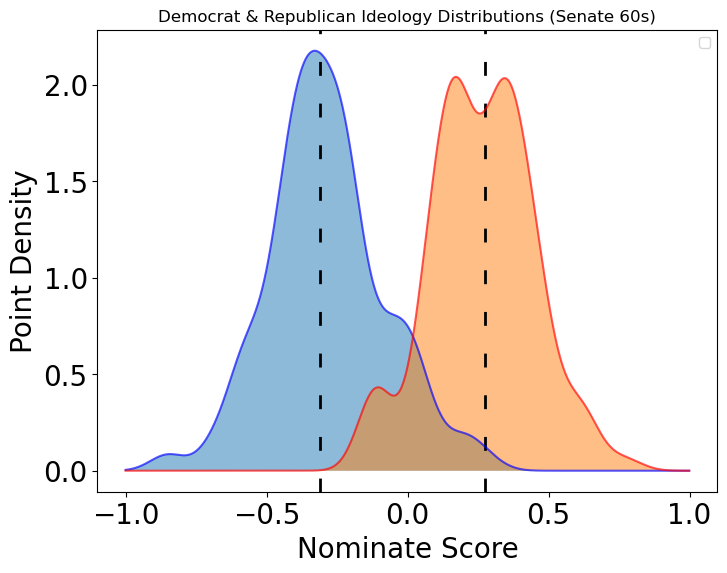

<ipython-input-16-0a0beaddfb77>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


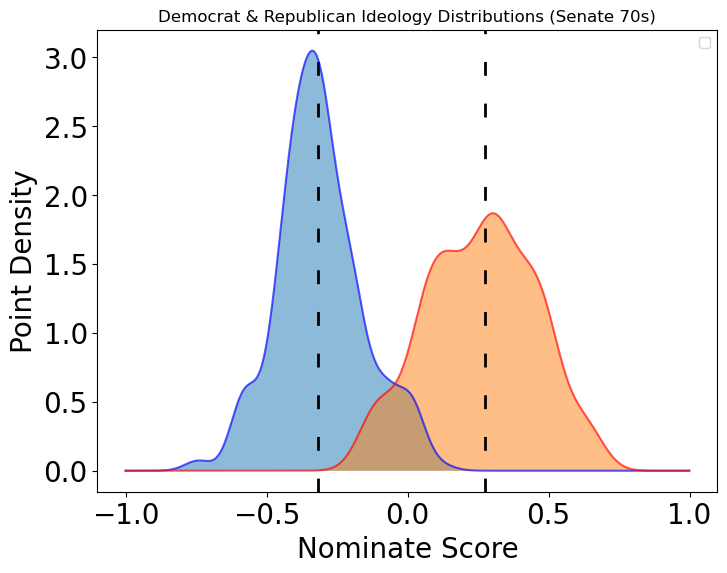

<ipython-input-16-0a0beaddfb77>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


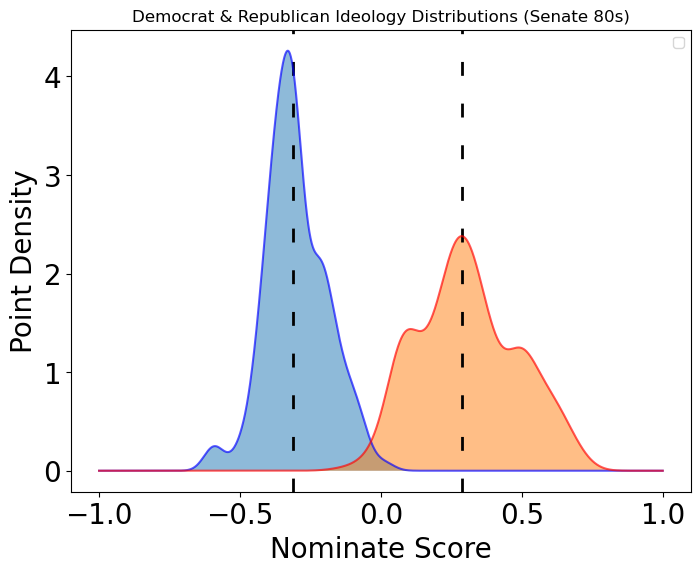

<ipython-input-16-0a0beaddfb77>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


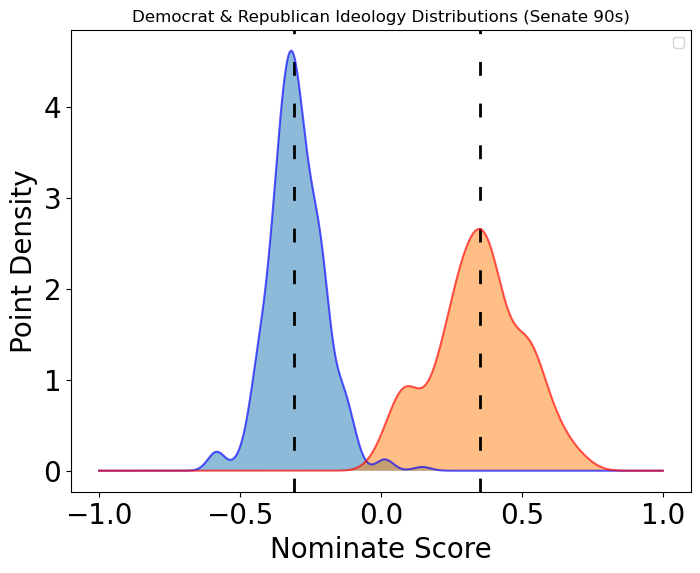

<ipython-input-16-0a0beaddfb77>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


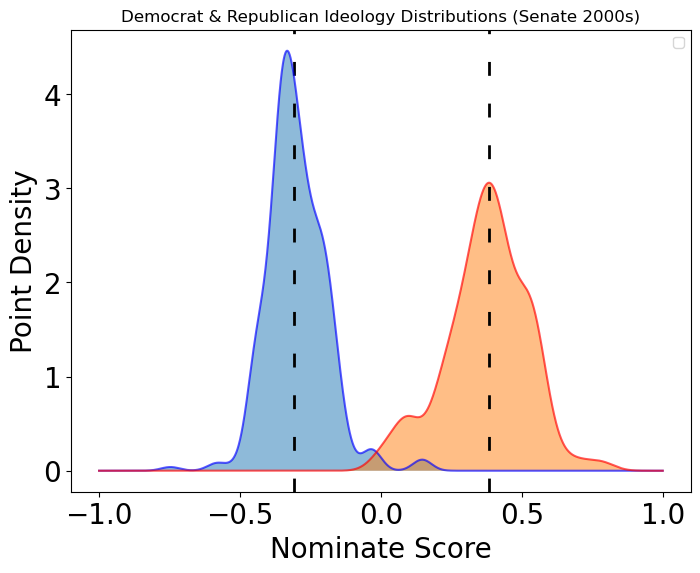

<ipython-input-16-0a0beaddfb77>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)
No handles with labels found to put in legend.


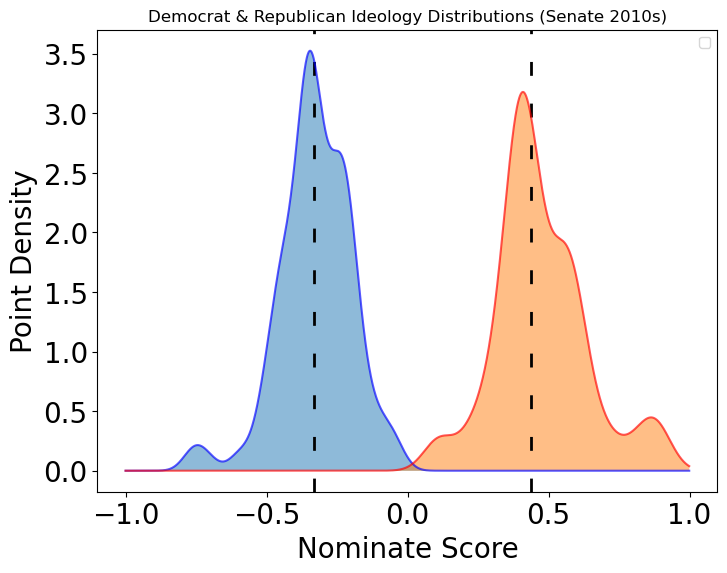

In [16]:
#Generates density plots for ideology scores by party collectively for all Senators in the decades since the 60s.
#These density plots summarize the overall ideological trends over the decades
jumps = [(86,91, '60s'), (91,96, '70s'), (96,101, '80s'), (101,106, '90s'), (106,111, '2000s'), (111,117, '2010s')]
for j in jumps:
    run_data = nominate_scores[(j[0] <= nominate_scores['congress']) & (nominate_scores['congress'] <= j[1]) & (nominate_scores['chamber'] == 'Senate')]
    run_data.sort_values(by=['nominate_dim1'], inplace = True)
    run_data.reset_index(drop = True, inplace = True)
    dems = run_data[run_data['party_code'] == 'D']['nominate_dim1']
    dems = dems[~np.isnan(dems)]
    dem_midp = np.median(dems)
    reps = run_data[run_data['party_code'] == 'R']['nominate_dim1']
    reps = reps[~np.isnan(reps)]
    rep_midp = np.median(reps)
    dem_density = gk(dems)
    rep_density = gk(reps)
    plt.figure(figsize=(8,6))
    plt.axvline(dem_midp, linewidth=2, dashes=[5,10], color='black')
    plt.axvline(rep_midp, linewidth=2, dashes=[5,10], color='black')
    plt.plot(np.arange(-1,1,0.001), dem_density(np.arange(-1,1,0.001)), color='blue', alpha = 0.65)
    plt.fill_between(np.arange(-1,1,0.001), dem_density(np.arange(-1,1,0.001)), alpha=0.5)
    plt.plot(np.arange(-1,1,0.001), rep_density(np.arange(-1,1,0.001)), color='red', alpha = 0.65)
    plt.fill_between(np.arange(-1,1,0.001), rep_density(np.arange(-1,1,0.001)), alpha=0.5)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.xlabel("Nominate Score", size=20)
    plt.ylabel("Point Density", size=20)
    plt.title("Democrat & Republican Ideology Distributions (Senate " + str(j[2]) + ')')
    plt.legend(loc='upper right')
    plt.show()
    

In [14]:
plt.rcdefaults()


<ipython-input-68-061a8835ce20>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)


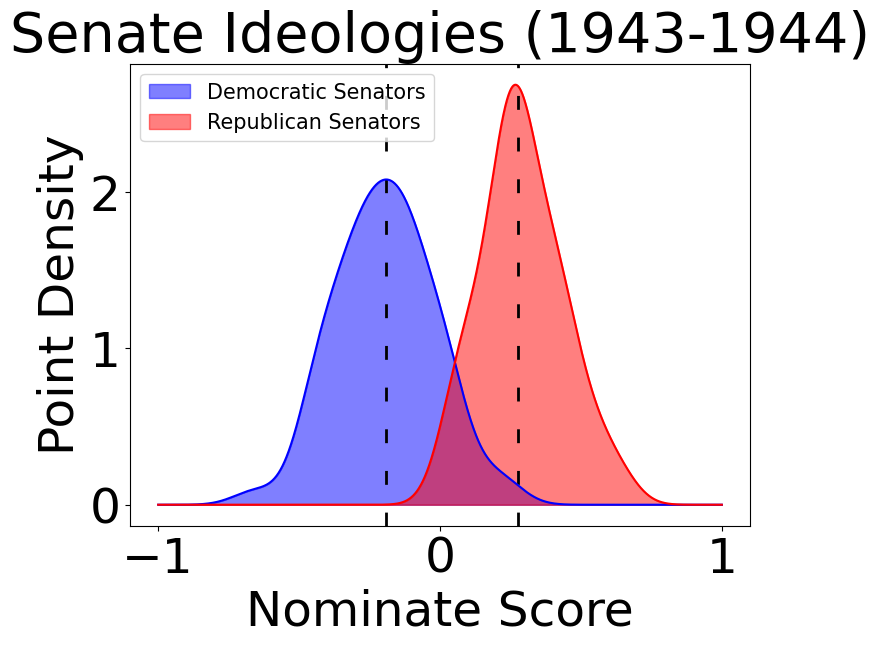

<ipython-input-68-061a8835ce20>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)


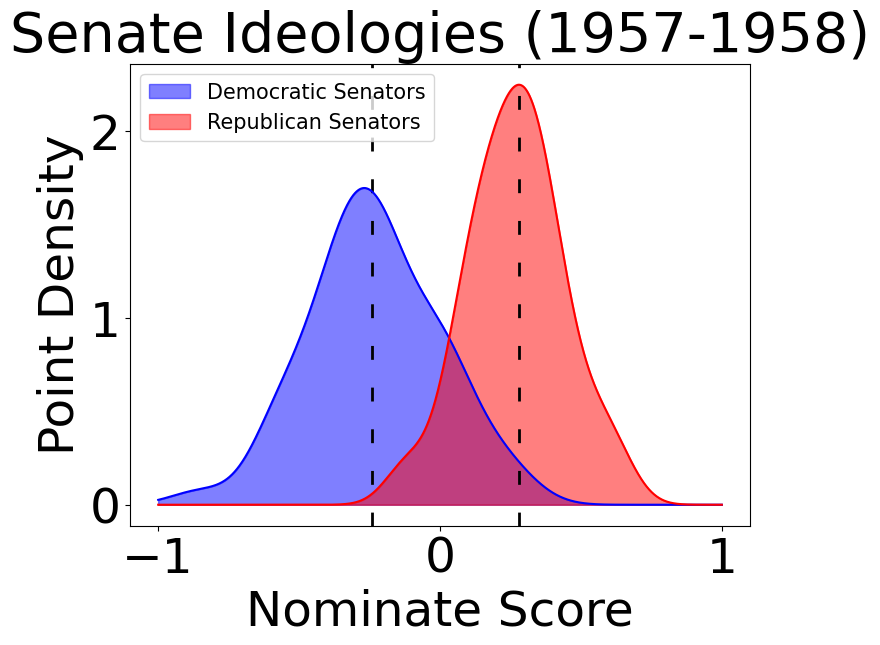

<ipython-input-68-061a8835ce20>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)


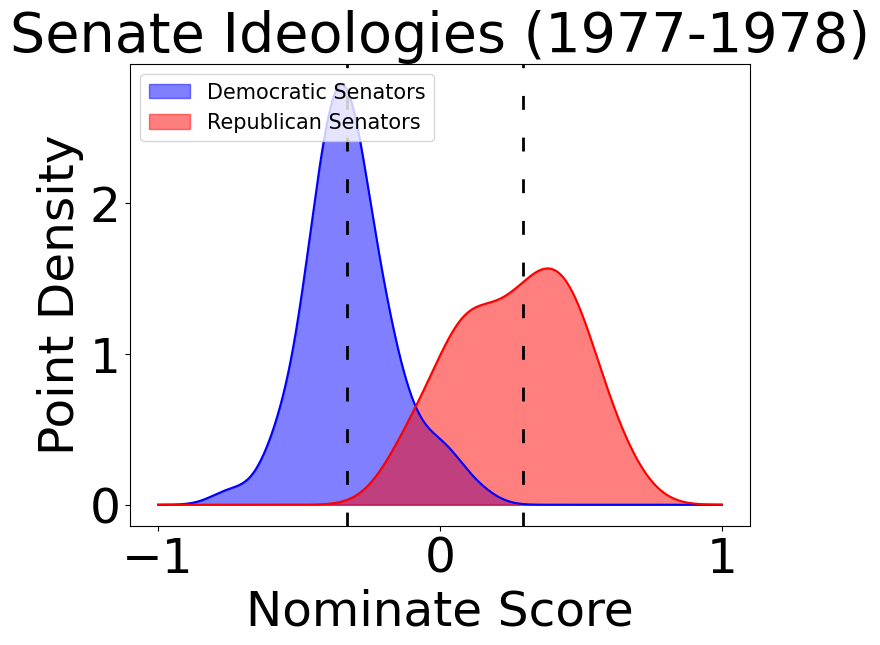

<ipython-input-68-061a8835ce20>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)


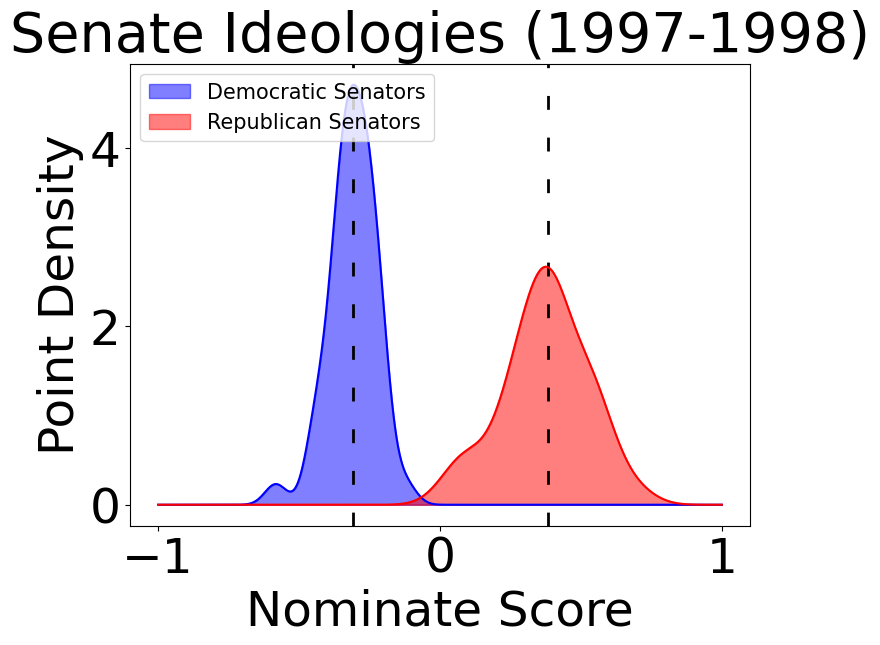

<ipython-input-68-061a8835ce20>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['nominate_dim1'], inplace = True)


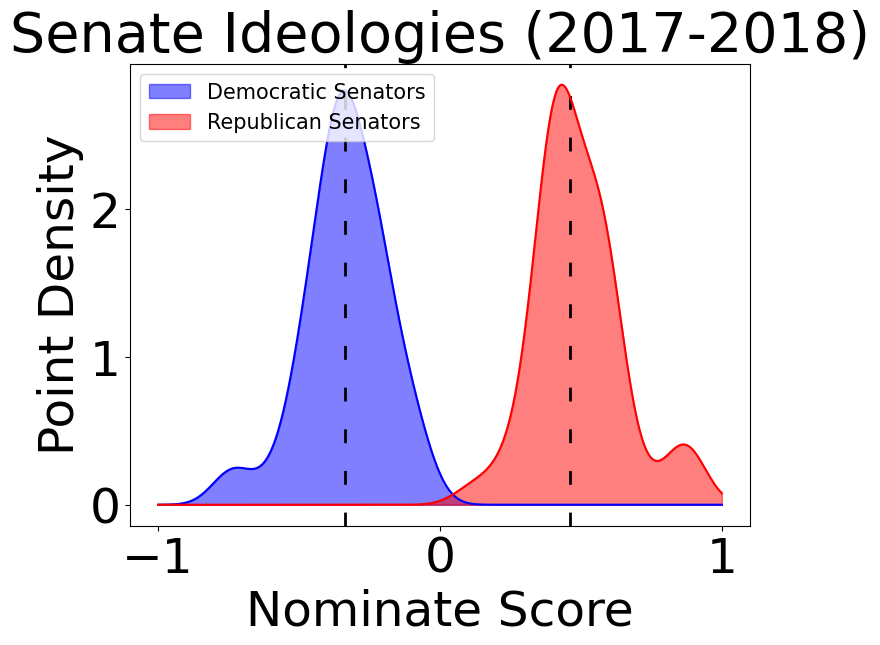

In [68]:
#Generates density curve plots for Senate ideologies of Democrats and Reublicans for Senates at regular intervals
pull = [78, 85, 95, 105, 115]
years = ['1943-1944', '1957-1958', '1977-1978', '1997-1998', '2017-2018']
for p in pull:
    run_data = nominate_scores[(nominate_scores['congress'] == p) & (nominate_scores['chamber'] == 'Senate')]
    run_data.sort_values(by=['nominate_dim1'], inplace = True)
    run_data.reset_index(drop = True, inplace = True)
    dems = run_data[run_data['party_code'] == 'D']['nominate_dim1']
    dems = dems[~np.isnan(dems)]
    dem_midp = np.median(dems)
    reps = run_data[run_data['party_code'] == 'R']['nominate_dim1']
    reps = reps[~np.isnan(reps)]
    rep_midp = np.median(reps)
    dem_density = gk(dems)
    rep_density = gk(reps)
    plt.figure(figsize=(8,6))
    plt.axvline(dem_midp, linewidth=2, dashes=[5,10], color='black')
    plt.axvline(rep_midp, linewidth=2, dashes=[5,10], color='black')
    plt.plot(np.arange(-1,1,0.001), dem_density(np.arange(-1,1,0.001)), color='blue')
    plt.fill_between(np.arange(-1,1,0.001), dem_density(np.arange(-1,1,0.001)), color='blue', alpha=0.5, label='Democratic Senators')
    plt.plot(np.arange(-1,1,0.001), rep_density(np.arange(-1,1,0.001)), color='red')
    plt.fill_between(np.arange(-1,1,0.001), rep_density(np.arange(-1,1,0.001)),color='red', alpha=0.5, label='Republican Senators')
    plt.tick_params(axis='x', labelsize=35)
    plt.tick_params(axis='y', labelsize=35)
    plt.xlabel("Nominate Score", size=35)
    year_index = pull.index(p)
    plt.ylabel("Point Density", size=35)
    plt.legend(loc='upper left' ,prop={'size': 15})
    plt.title('Senate Ideologies (' + years[year_index] + ')', size=40)
    plt.show()


<ipython-input-67-ed7b71f44718>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


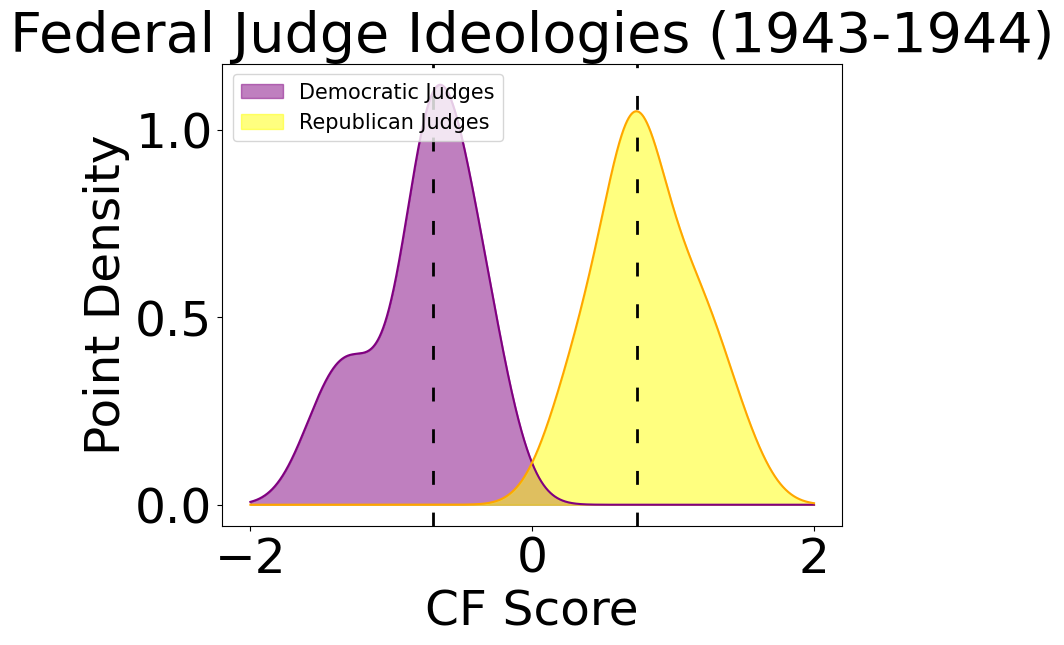

<ipython-input-67-ed7b71f44718>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


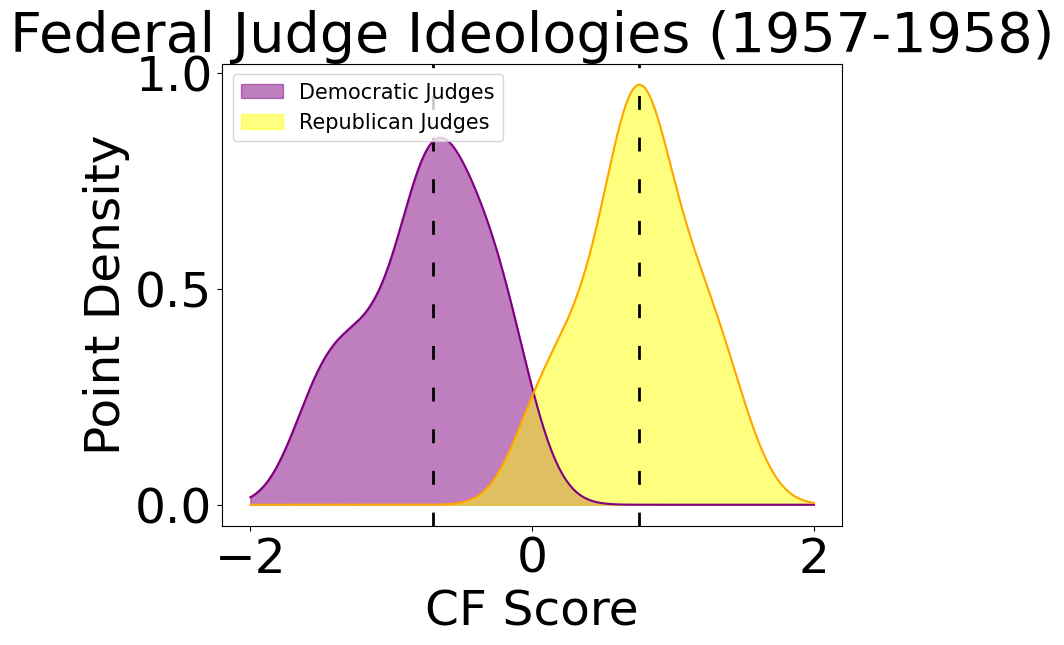

<ipython-input-67-ed7b71f44718>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


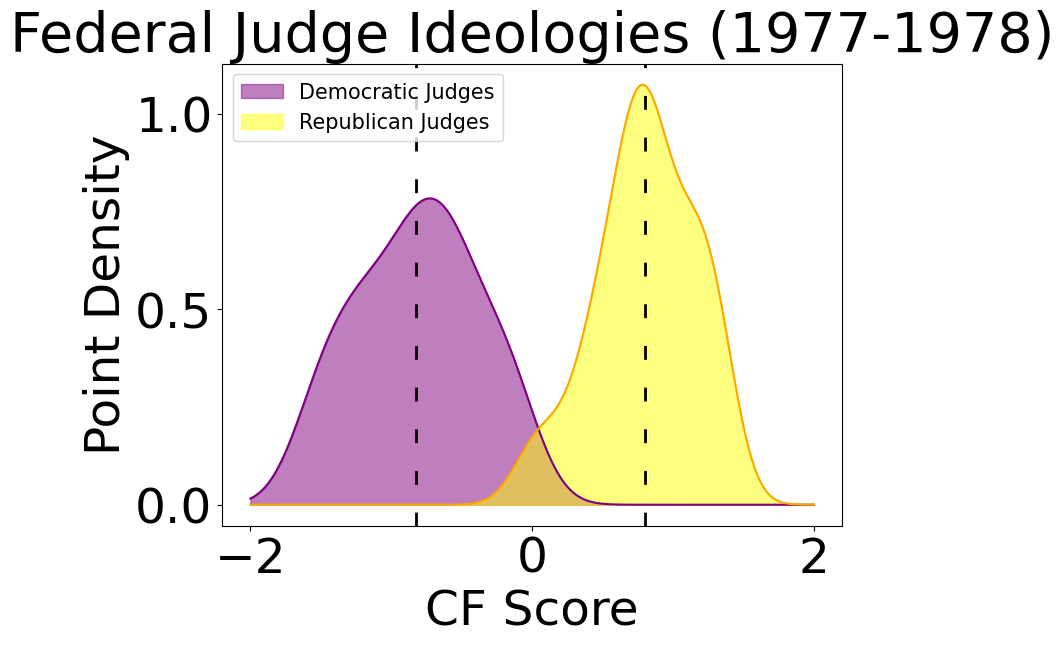

<ipython-input-67-ed7b71f44718>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


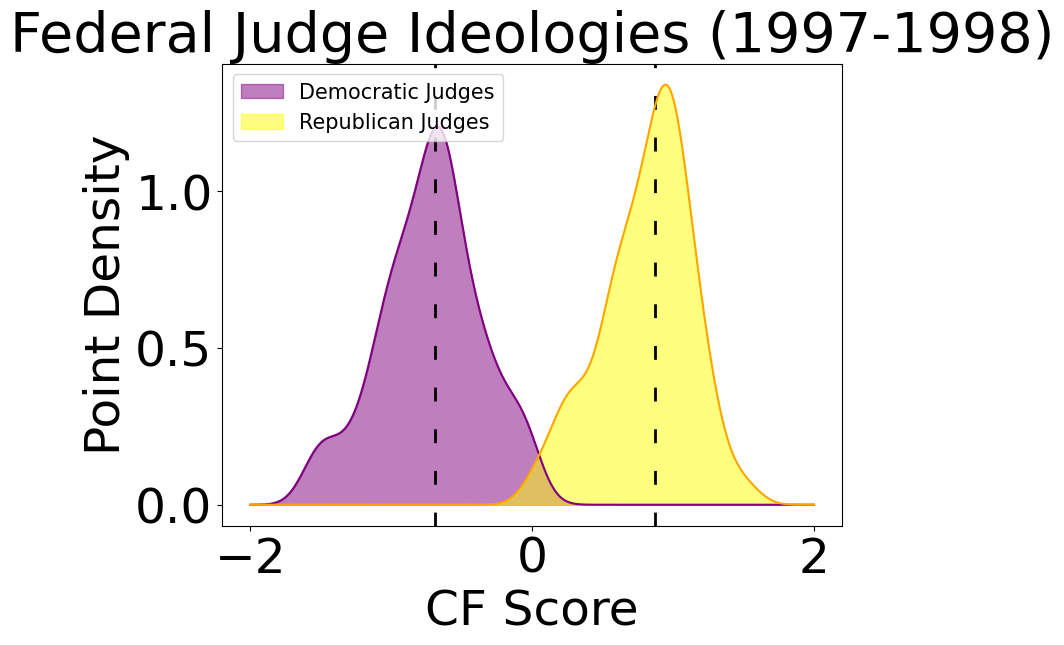

<ipython-input-67-ed7b71f44718>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


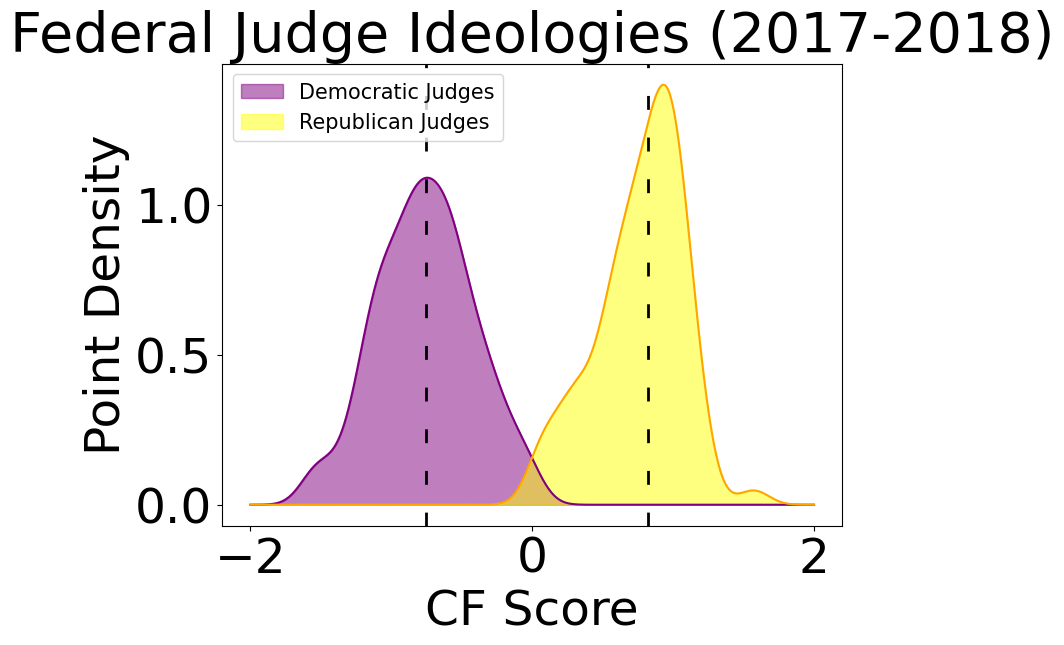

In [67]:
#Generates density curve plots for serving federal judge ideologies of Democrat and Reublican leaning judges
#at regular intervals
pull = [78, 85, 95, 105, 115]
years = ['1943-1944', '1957-1958', '1977-1978', '1997-1998', '2017-2018']
for p in pull:
    x = senate_stats_for_plot[senate_stats_for_plot['congress'] == p]['term_start'].values[0]
    y = senate_stats_for_plot[senate_stats_for_plot['congress'] == p]['term_end'].values[0]
    run_data = all_apt[(all_apt['term_start'].values <= y) & (x < all_apt['term_end'].values)]
    run_data.sort_values(by=['cf_score'], inplace = True)
    run_data.reset_index(drop = True, inplace = True)
    dems = run_data[run_data['party_leaning'] == 'D']['cf_score']
    dems = dems[~np.isnan(dems)]
    dem_midp = np.median(dems)
    reps = run_data[run_data['party_leaning'] == 'R']['cf_score']
    reps = reps[~np.isnan(reps)]
    rep_midp = np.median(reps)
    dem_density = gk(dems)
    rep_density = gk(reps)
    plt.figure(figsize=(8,6))
    plt.axvline(dem_midp, linewidth=2, dashes=[5,10], color='black')
    plt.axvline(rep_midp, linewidth=2, dashes=[5,10], color='black')
    plt.plot(np.arange(-2,2,0.001), dem_density(np.arange(-2,2,0.001)), color='purple')
    plt.fill_between(np.arange(-2,2,0.001), dem_density(np.arange(-2,2,0.001)), color='purple', alpha=0.5, label='Democratic Judges')
    plt.plot(np.arange(-2,2,0.001), rep_density(np.arange(-2,2,0.001)), color='orange')
    plt.fill_between(np.arange(-2,2,0.001), rep_density(np.arange(-2,2,0.001)), color='yellow', alpha=0.5, label='Republican Judges')
    plt.tick_params(axis='x', labelsize=35)
    plt.tick_params(axis='y', labelsize=35)
    plt.xlabel("CF Score", size=35)
    plt.ylabel("Point Density", size=35)
    plt.legend(loc='upper left' ,prop={'size': 15})
    year_index = pull.index(p)
    plt.title('Federal Judge Ideologies (' + years[year_index] + ')', size=40)
    plt.show()


<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


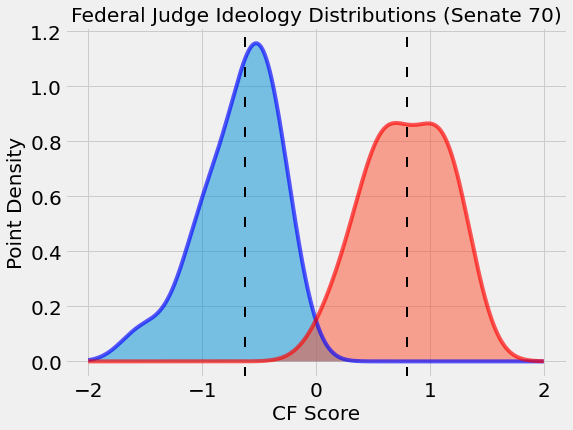

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


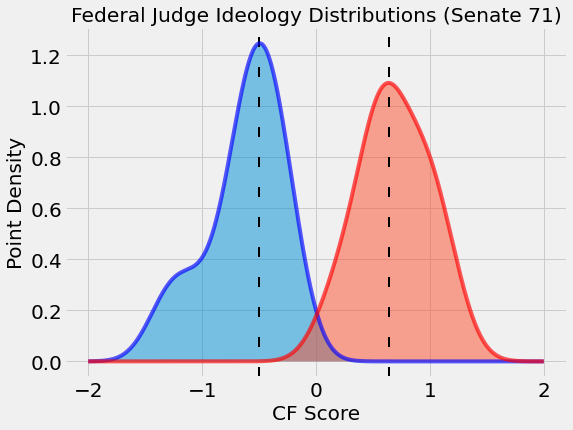

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


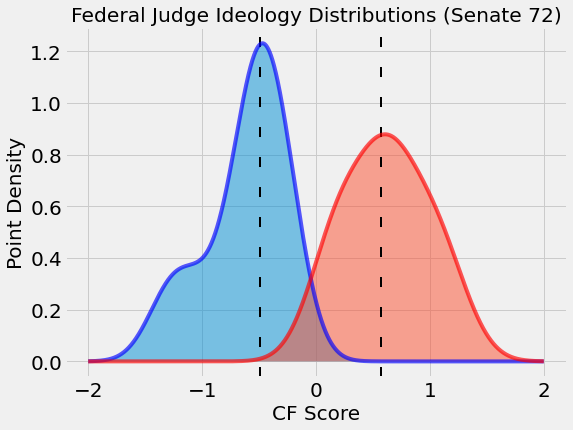

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


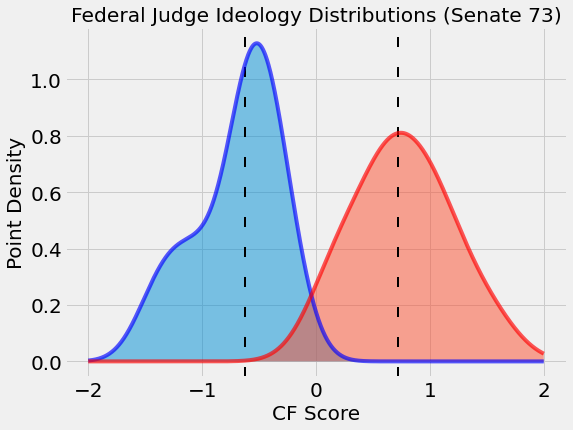

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


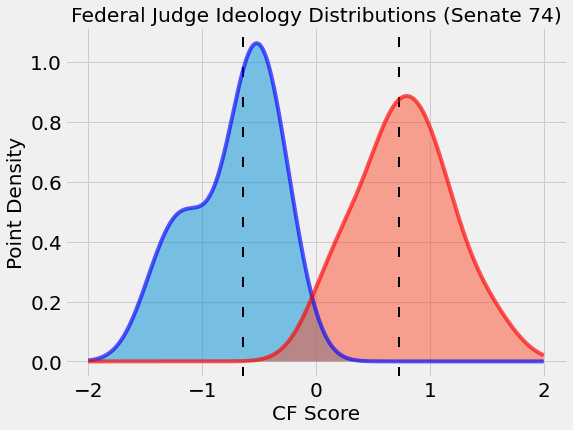

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


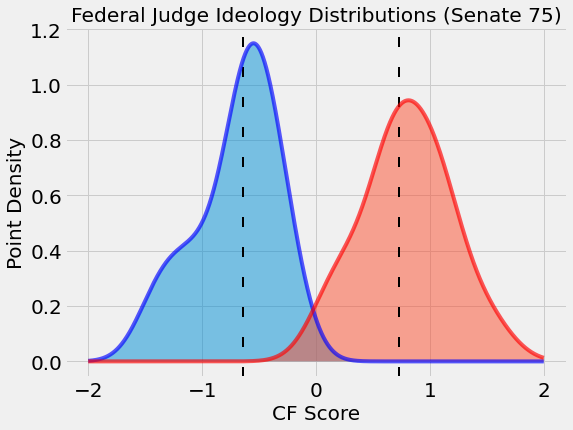

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


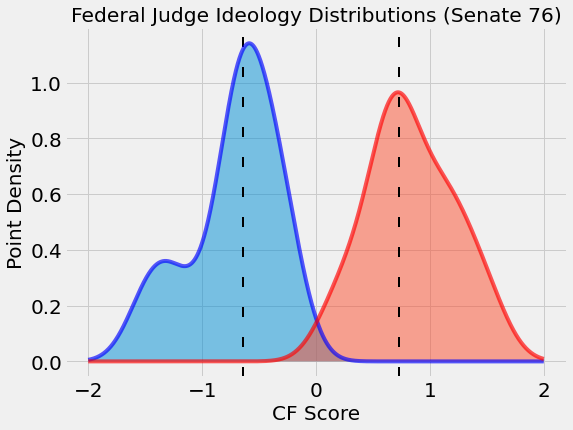

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


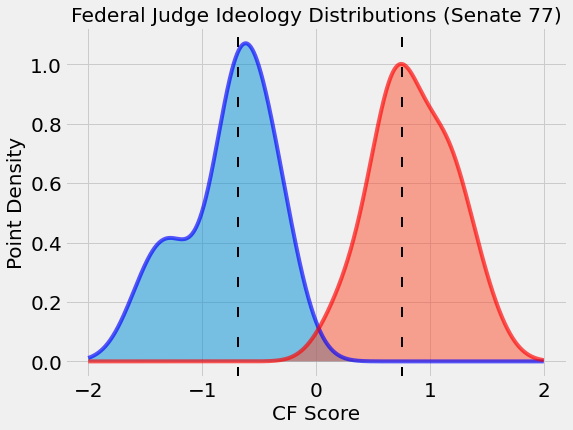

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


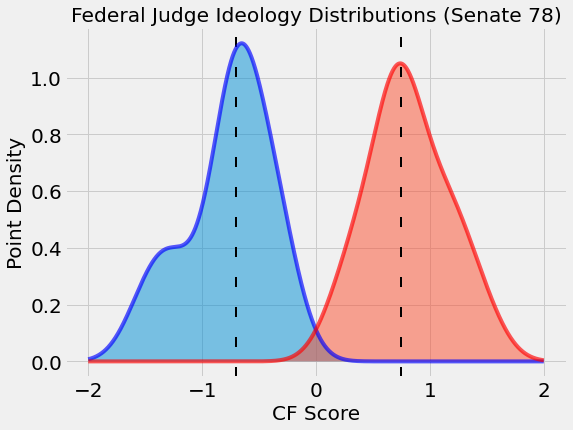

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


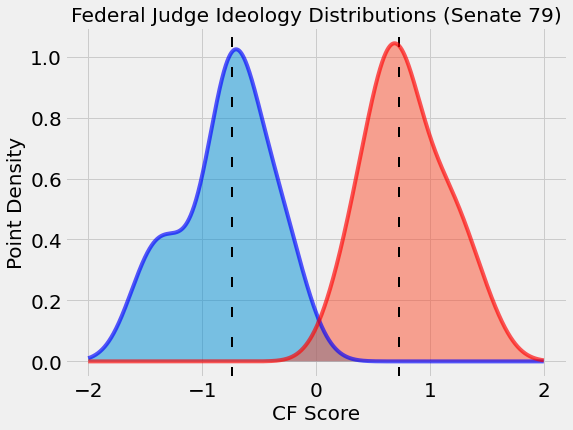

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


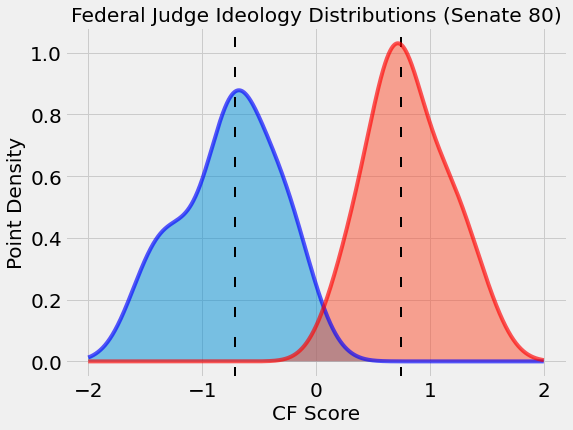

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


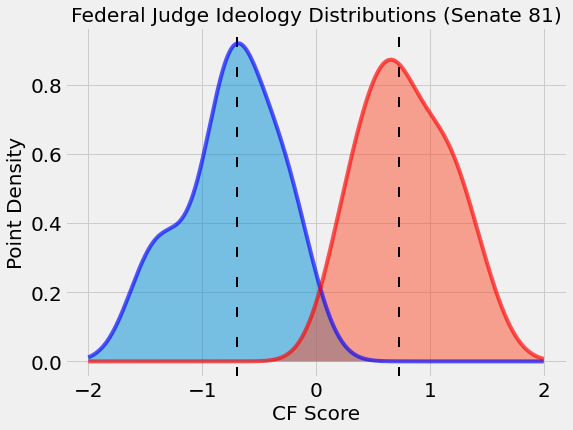

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


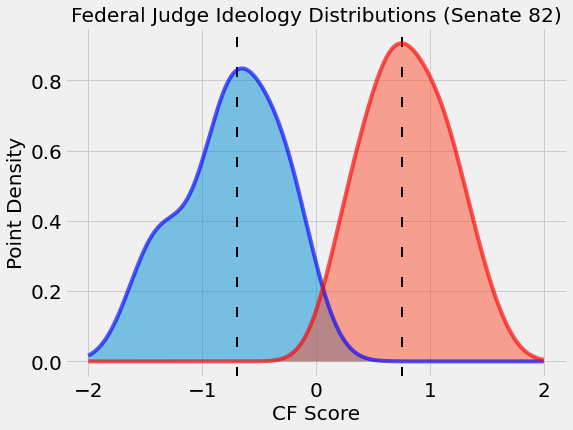

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


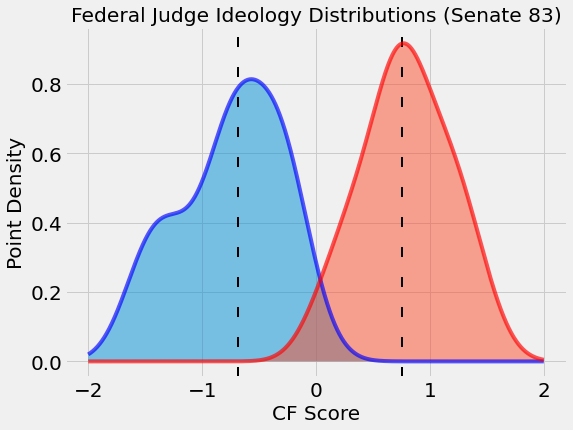

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


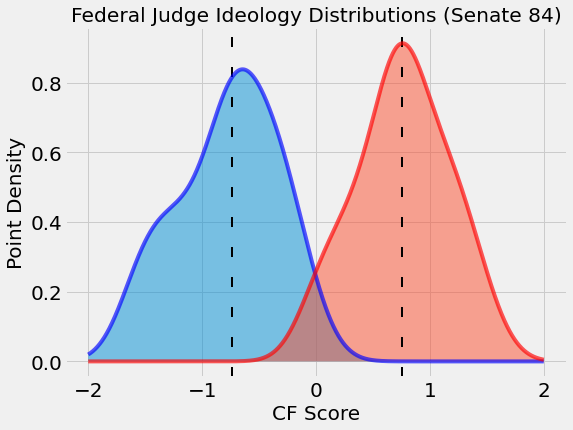

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


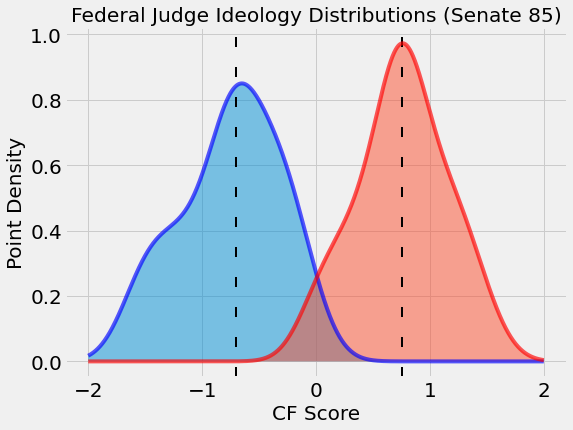

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


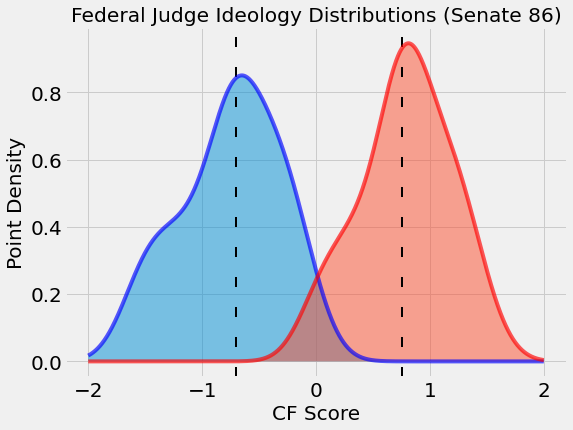

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


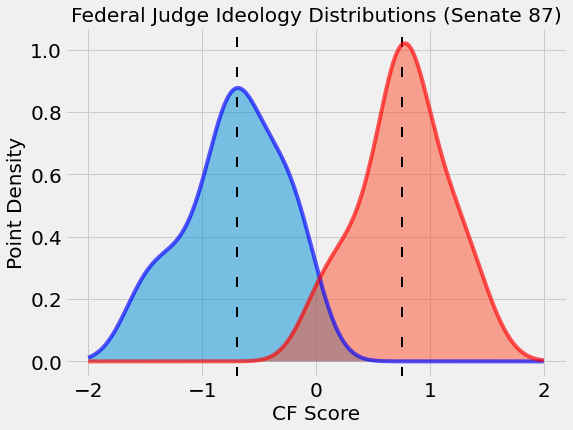

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


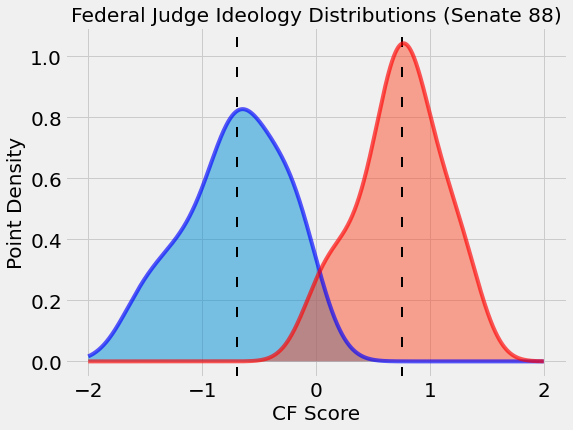

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


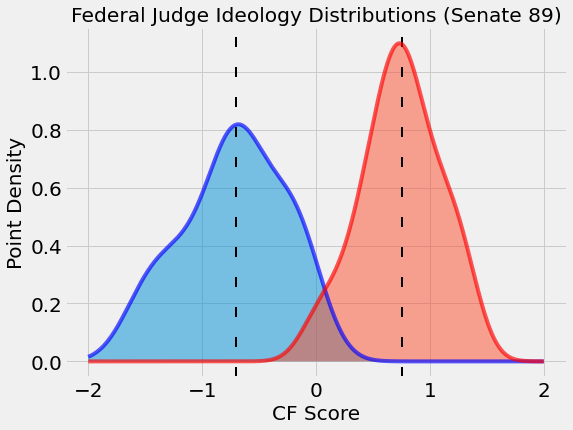

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


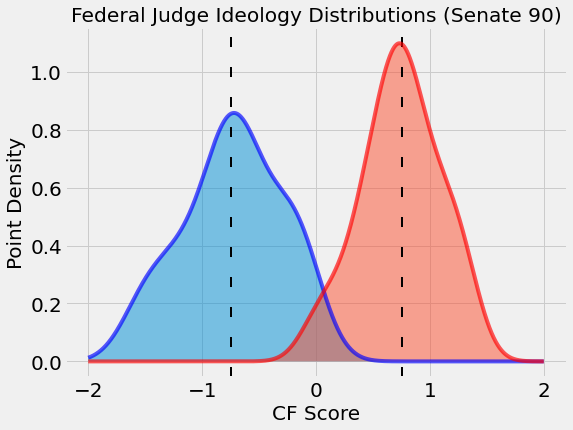

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


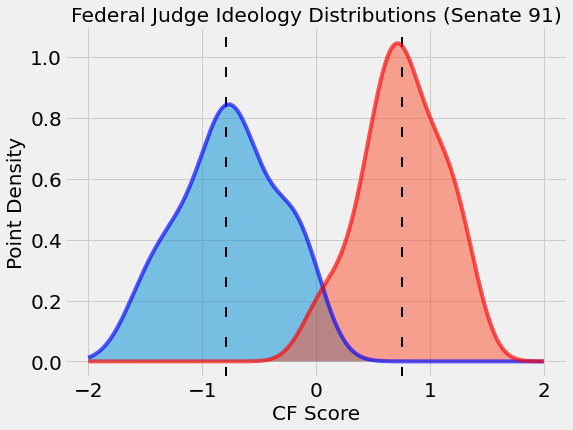

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


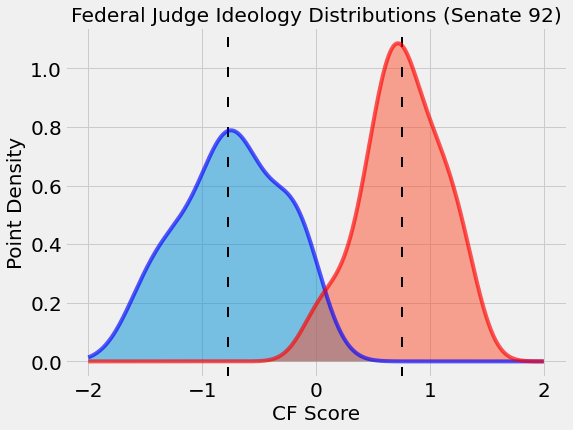

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


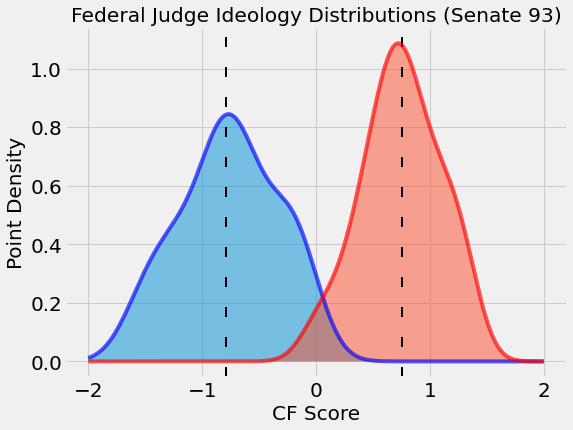

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


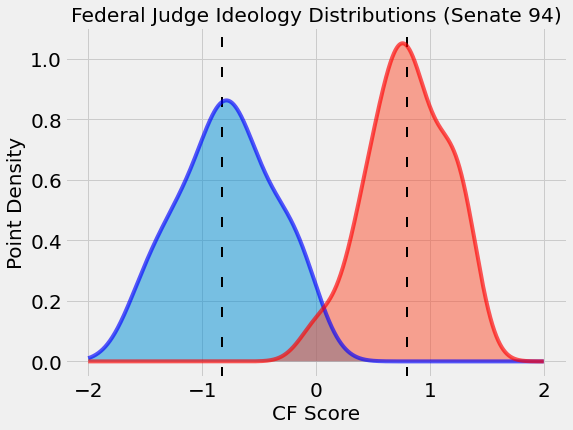

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


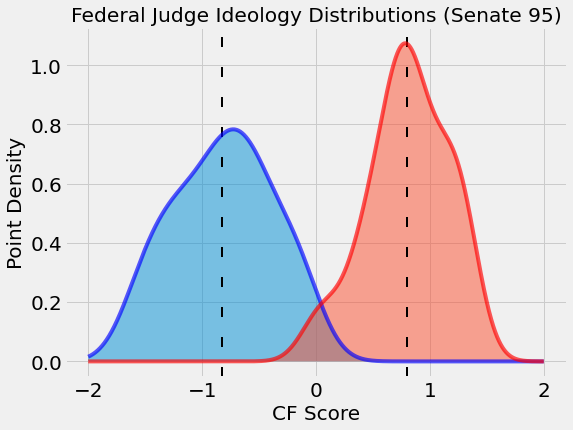

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


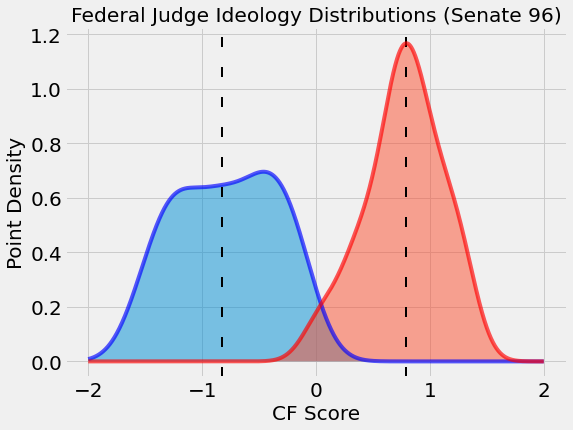

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


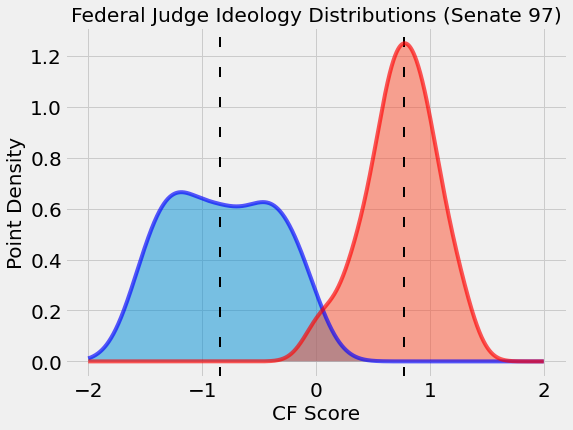

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


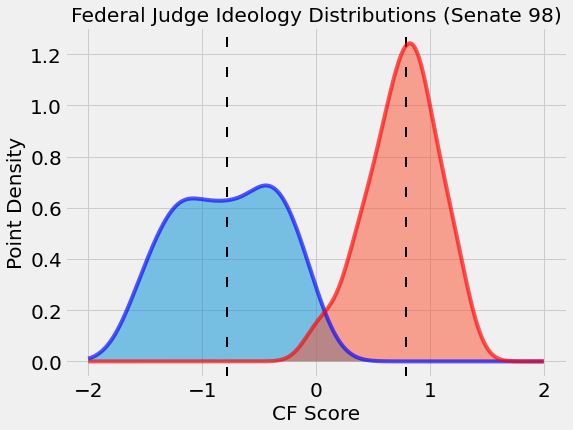

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


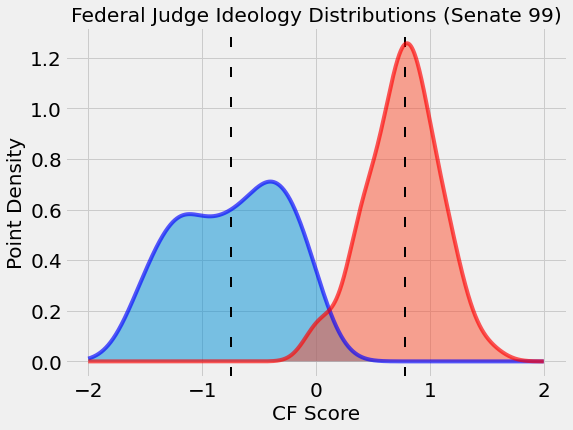

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


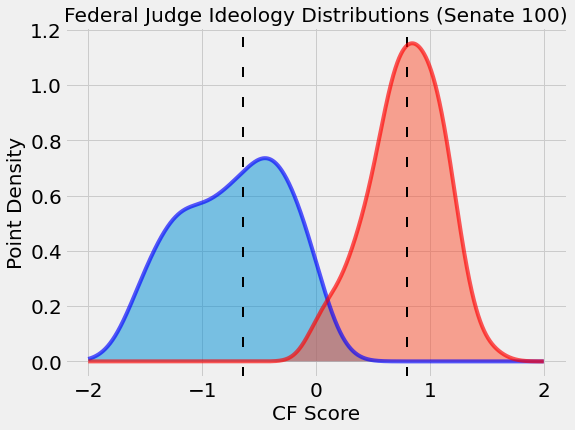

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


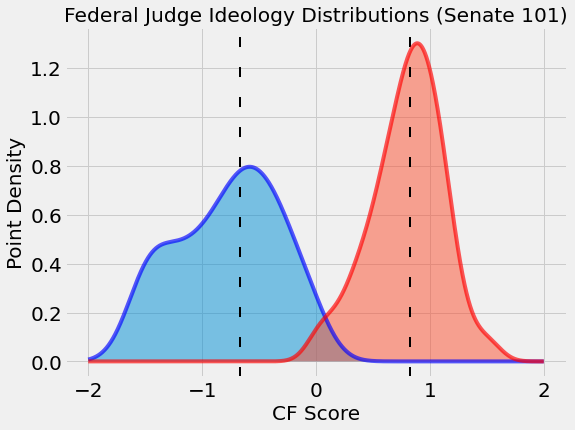

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


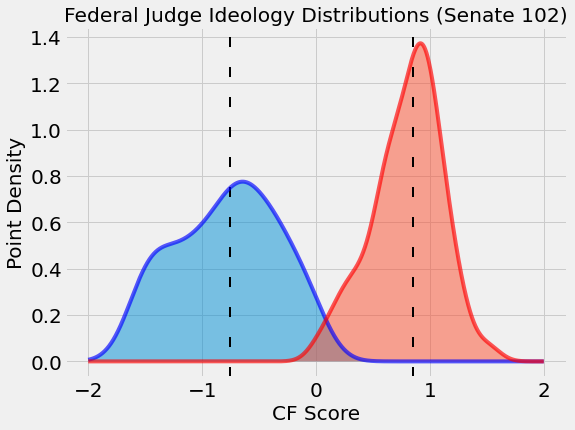

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


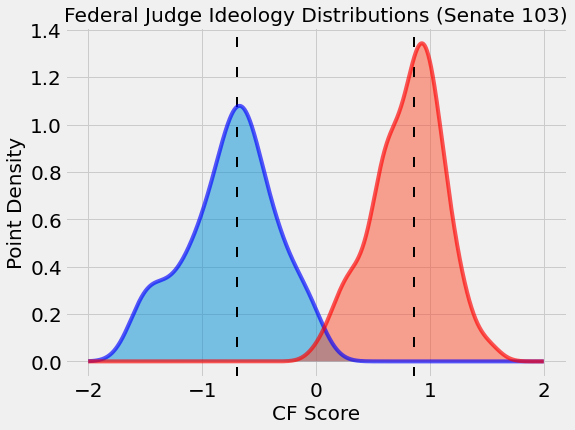

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


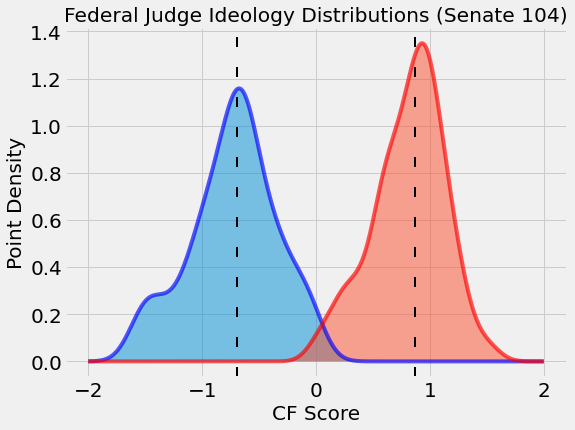

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


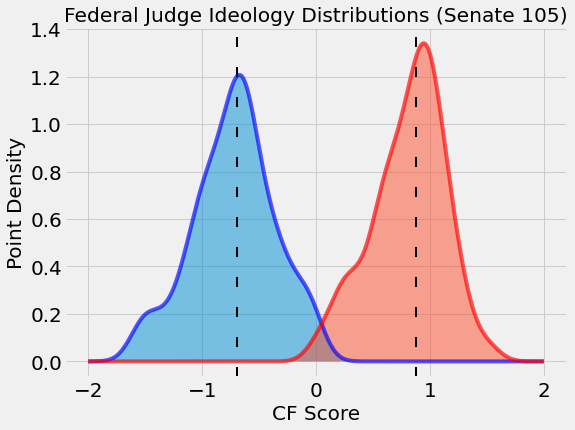

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


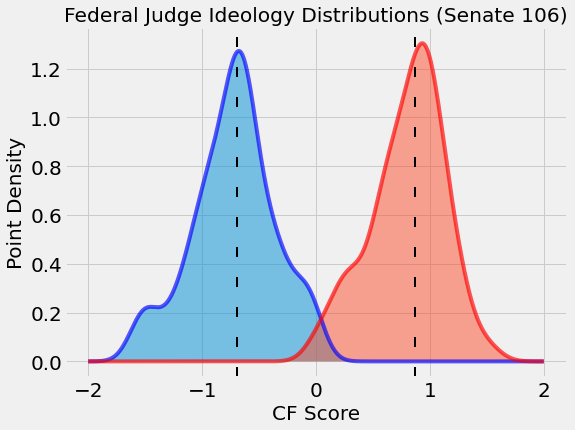

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


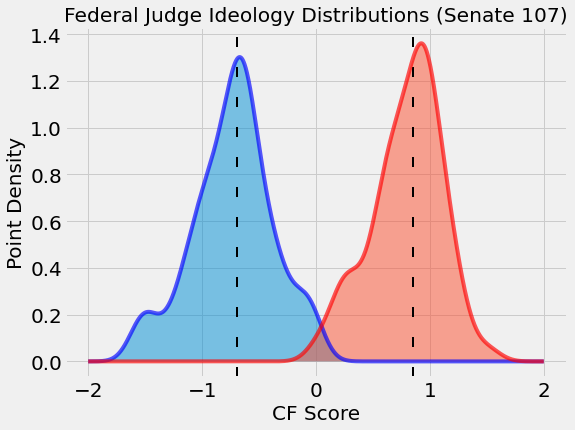

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


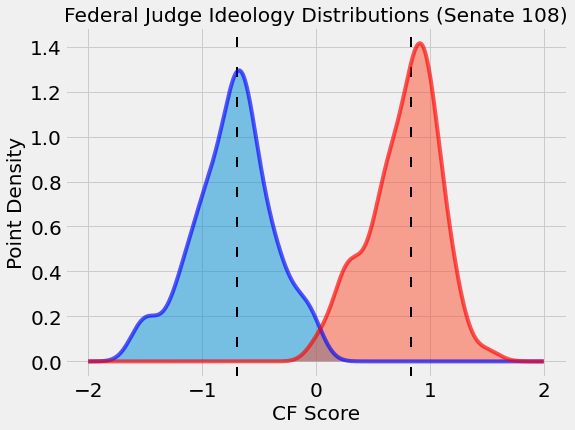

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


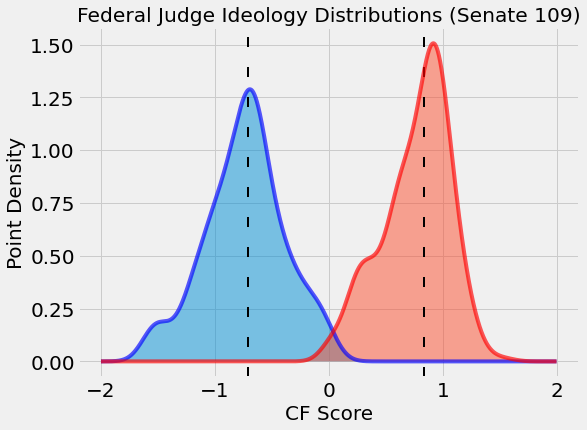

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


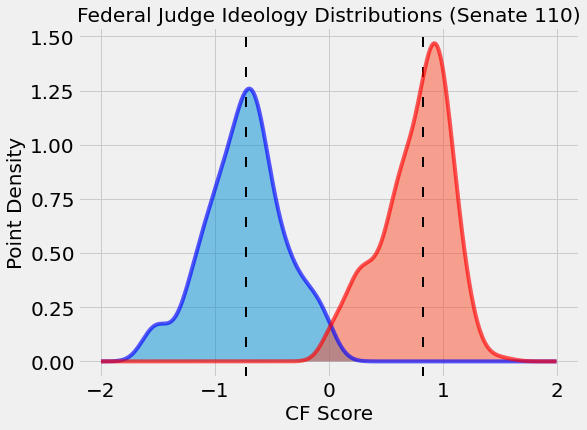

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


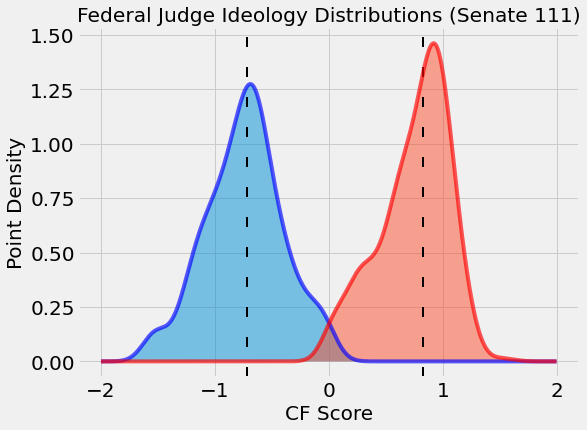

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


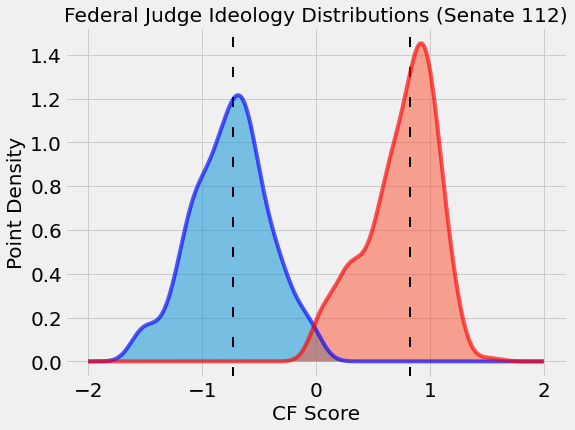

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


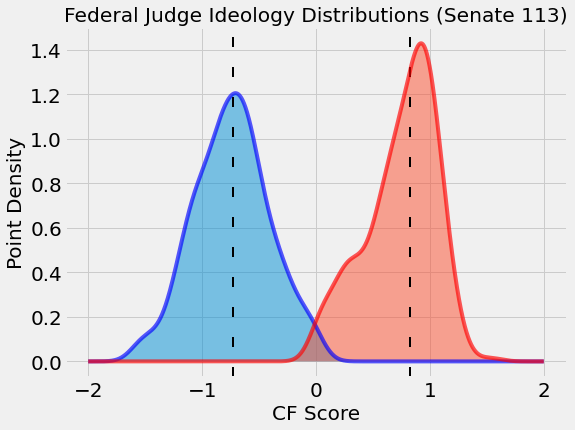

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


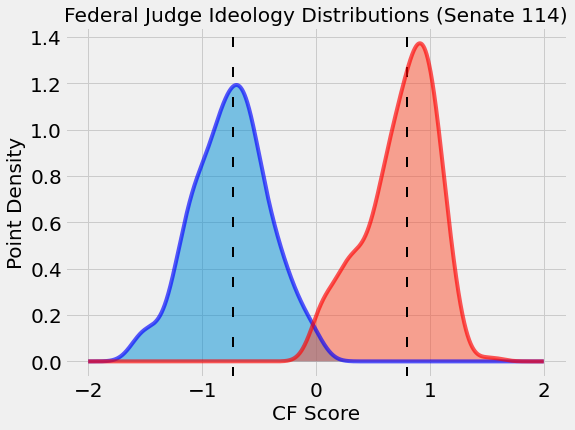

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


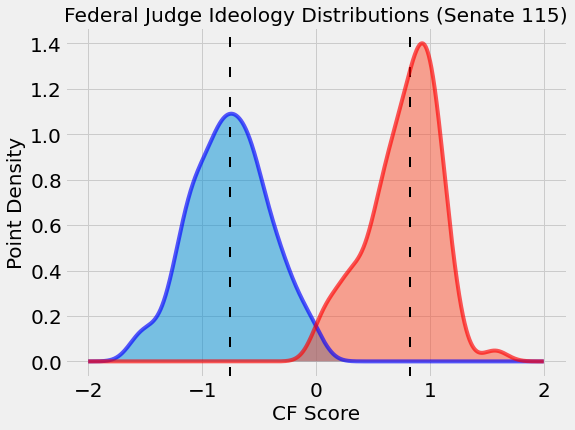

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


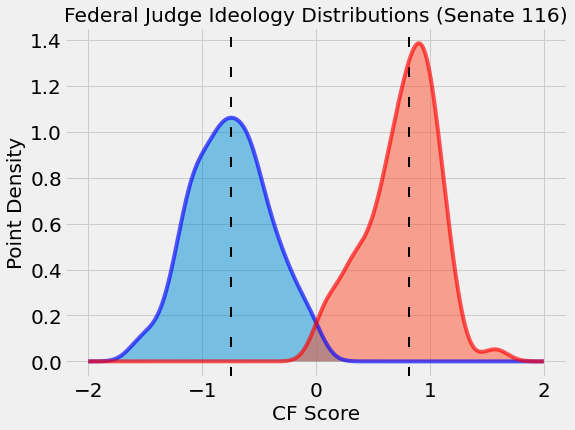

<ipython-input-64-0a336982b87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)


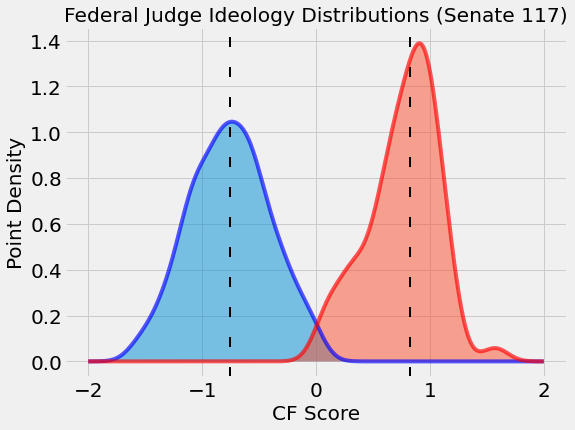

In [64]:
#Generates density curve plots for Senate ideologies of Democrats and Reublicans for each Senate 
#since the 70th Congress (1927-1929)
for i in range(70, 118):
    x = senate_stats_for_plot[senate_stats_for_plot['congress'] == i]['term_start'].values[0]
    y = senate_stats_for_plot[senate_stats_for_plot['congress'] == i]['term_end'].values[0]
    run_data = all_apt[(all_apt['term_start'].values <= y) & (x < all_apt['term_end'].values)]
    run_data.sort_values(by=['cf_score'], inplace = True)
    run_data.reset_index(drop = True, inplace = True)
    dems = run_data[run_data['party_leaning'] == 'D']['cf_score']
    dems = dems[~np.isnan(dems)]
    dem_midp = np.median(dems)
    reps = run_data[run_data['party_leaning'] == 'R']['cf_score']
    reps = reps[~np.isnan(reps)]
    rep_midp = np.median(reps)
    dem_density = gk(dems)
    rep_density = gk(reps)
    plt.figure(figsize=(8,6))
    plt.axvline(dem_midp, linewidth=2, dashes=[5,10], color='black')
    plt.axvline(rep_midp, linewidth=2, dashes=[5,10], color='black')
    plt.plot(np.arange(-2,2,0.001), dem_density(np.arange(-2,2,0.001)), color='blue', alpha = 0.65)
    plt.fill_between(np.arange(-2,2,0.001), dem_density(np.arange(-2,2,0.001)), alpha=0.5)
    plt.plot(np.arange(-2,2,0.001), rep_density(np.arange(-2,2,0.001)), color='red', alpha = 0.65)
    plt.fill_between(np.arange(-2,2,0.001), rep_density(np.arange(-2,2,0.001)), alpha=0.5)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.xlabel("CF Score", size=20)
    plt.ylabel("Point Density", size=20)
    plt.title("Federal Judge Ideology Distributions (Senate " + str(i) + ')')
    plt.show()
    


In [94]:
#Counts the number of federal judge observations that contain a valid ideology score by Congressional term
valid_scores = np.array([])
for c in senate_stats_for_plot['congress']:
    x = senate_stats_for_plot[senate_stats_for_plot['congress'] == c]['term_start'].values[0]
    y = senate_stats_for_plot[senate_stats_for_plot['congress'] == c]['term_end'].values[0]
    run_data = all_apt[(all_apt['term_start'].values <= y) & (x < all_apt['term_end'].values)]
    run_data.sort_values(by=['cf_score'], inplace = True)
    run_data.reset_index(drop = True, inplace = True)
    leng = len(run_data[run_data['cf_score'].notnull()])
    valid_scores = np.append(valid_scores, leng)

senate_stats_for_plot['num_valid'] = valid_scores



<ipython-input-94-88186ddb56ef>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)
<ipython-input-94-88186ddb56ef>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)
<ipython-input-94-88186ddb56ef>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data.sort_values(by=['cf_score'], inplace = True)
<ipython-input-94-88186ddb56ef>:6:

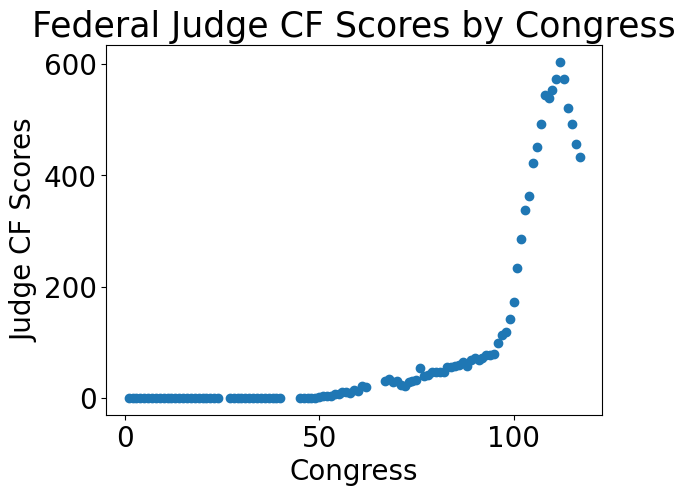

In [95]:
#Plots the number of federal judge ideology scores in the data for each Congressional number
plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['num_valid'])
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.title('Federal Judge CF Scores by Congress', size =25)
plt.xlabel('Congress', size=20)
plt.ylabel('Judge CF Scores', size=20)
plt.show()


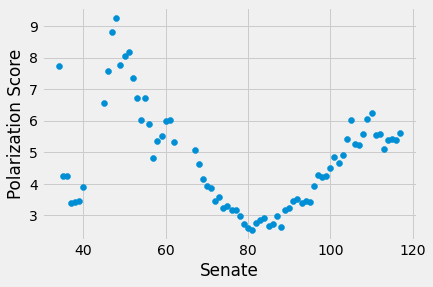

In [40]:
#Plots Senate polarization score by Congressional number
plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['polarization_score'])
plt.xlabel('Senate')
plt.ylabel('Polarization Score')
plt.show()


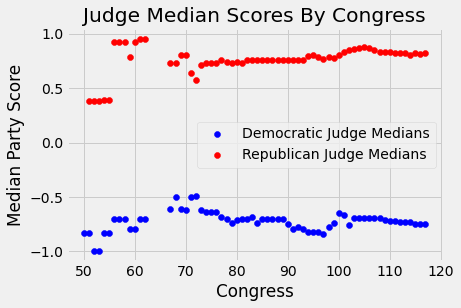

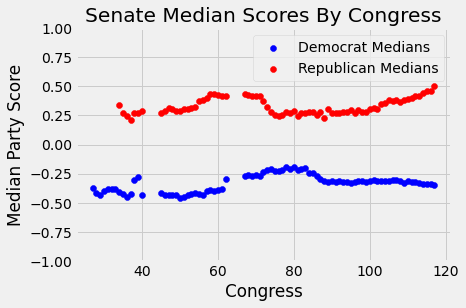

In [46]:
#Plots median ideology scores for Democrat and Republican leaning Senators and federal judges.
plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['judge_dem_median'], c='blue', label='Democratic Judge Medians')
plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['judge_rep_median'], c='red', label='Republican Judge Medians')
plt.xlabel('Congress')
plt.ylabel('Median Party Score')
plt.title('Judge Median Scores By Congress')
plt.legend(loc='best')
plt.show()

plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['dem_median'], c='blue', label='Democrat Medians')
plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['rep_median'], c='red', label='Republican Medians')
plt.xlabel('Congress')
plt.ylabel('Median Party Score')
plt.title('Senate Median Scores By Congress')
plt.legend(loc='best')
plt.ylim(-1,1)
plt.show()


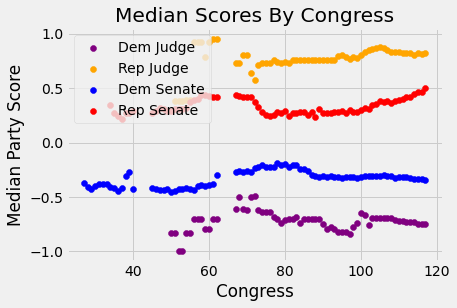

In [48]:
plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['judge_dem_median'], c='purple', label='Dem Judge')
plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['judge_rep_median'], c='orange', label='Rep Judge')
plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['dem_median'], c='blue', label='Dem Senate')
plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['rep_median'], c='red', label='Rep Senate')
plt.xlabel('Congress')
plt.ylabel('Median Party Score')
plt.title('Median Scores By Congress')
plt.legend(loc='best')
plt.show()


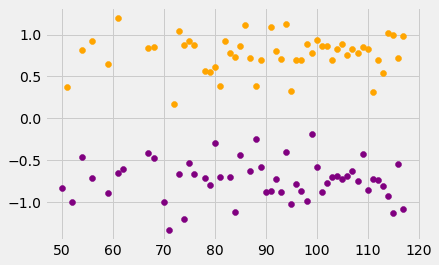

In [64]:
#Plots median ideology scores for just the Democrat and Republican leaning federal judges that were appointed
#duringt that congressional term
plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['apt_dem_median'], c='purple', label='Dem Judge')
plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['apt_rep_median'], c='orange', label='Rep Judge')
plt.legend(loc='best')
plt.show()


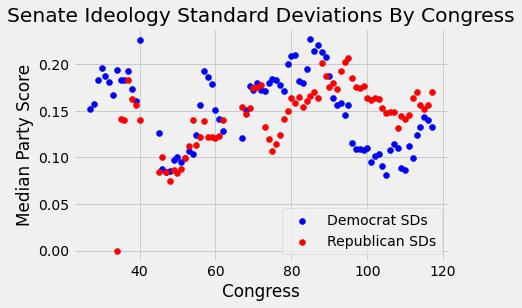

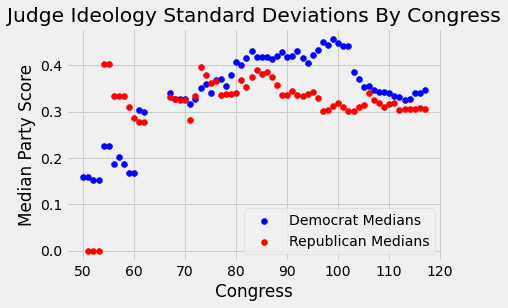

In [47]:
#Plots senate and federal judge ideology stadard deviations separated by party by congress number
plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['dem_std'], c='blue', label='Democrat SDs')
plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['rep_std'], c='red', label='Republican SDs')
plt.xlabel('Congress')
plt.ylabel('Median Party Score')
plt.title('Senate Ideology Standard Deviations By Congress')
plt.legend(loc='best')
plt.show()

plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['judge_dem_std'], c='blue', label='Democrat Medians')
plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['judge_rep_std'], c='red', label='Republican Medians')
plt.xlabel('Congress')
plt.ylabel('Median Party Score')
plt.title('Judge Ideology Standard Deviations By Congress')
plt.legend(loc='best')
plt.show()



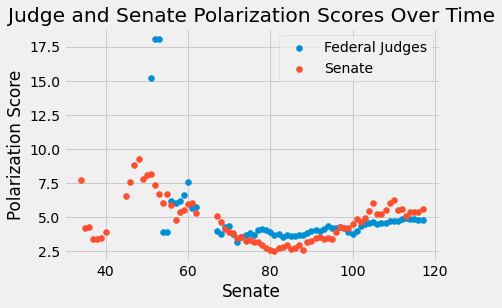

In [55]:
plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['judge_polarization_score'], label='Federal Judges')
plt.scatter(senate_stats_for_plot['congress'], senate_stats_for_plot['polarization_score'], label='Senate')
plt.xlabel('Senate')
plt.ylabel('Polarization Score')
plt.title('Judge and Senate Polarization Scores Over Time')
plt.legend(loc='best')
plt.show()


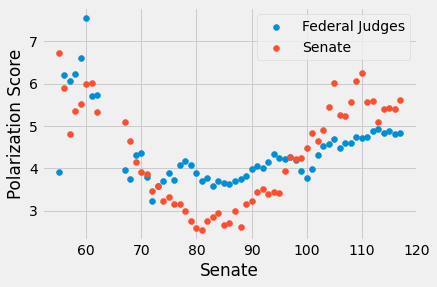

In [41]:
reduced_senate_stats = senate_stats_for_plot[senate_stats_for_plot['congress'] >= 55]
plt.scatter(reduced_senate_stats['congress'], reduced_senate_stats['judge_polarization_score'], label='Federal Judges')
plt.scatter(reduced_senate_stats['congress'], reduced_senate_stats['polarization_score'], label='Senate')
plt.xlabel('Senate')
plt.ylabel('Polarization Score')
plt.legend(loc='best')
plt.show()


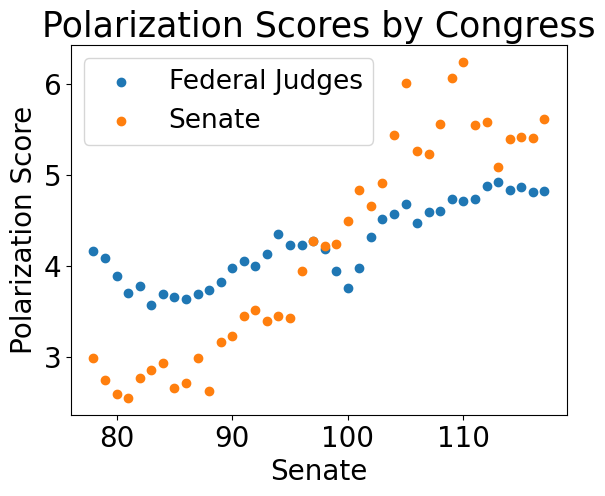

In [105]:
#Plots polarization scores by congressional term for both active federal judges and Senators to explore
#the relationship between the two. 
#The plotted data starts with the 78th congress to ensure each judge polarization score is pulling from at least
#100 judge ideology data points
reduced_senate_stats = senate_stats_for_plot[senate_stats_for_plot['congress'] >= 78]
plt.scatter(reduced_senate_stats['congress'], reduced_senate_stats['judge_polarization_score'], label='Federal Judges')
plt.scatter(reduced_senate_stats['congress'], reduced_senate_stats['polarization_score'], label='Senate')
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlabel('Senate', size=20)
plt.ylabel('Polarization Score', size=20)
plt.title('Polarization Scores by Congress', size=25)
plt.legend(loc='best', prop={'size': 19})
plt.show()


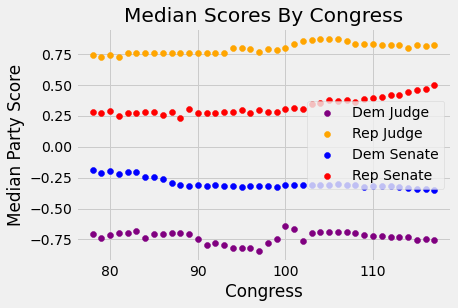

In [49]:
#Plots median ideology scores for all partisan leanings of both active federal judges and Senators
plt.scatter(reduced_senate_stats['congress'], reduced_senate_stats['judge_dem_median'], c='purple', label='Dem Judge')
plt.scatter(reduced_senate_stats['congress'], reduced_senate_stats['judge_rep_median'], c='orange', label='Rep Judge')
plt.scatter(reduced_senate_stats['congress'], reduced_senate_stats['dem_median'], c='blue', label='Dem Senate')
plt.scatter(reduced_senate_stats['congress'], reduced_senate_stats['rep_median'], c='red', label='Rep Senate')
plt.xlabel('Congress')
plt.ylabel('Median Party Score')
plt.title('Median Scores By Congress')
plt.legend(loc='best')
plt.show()


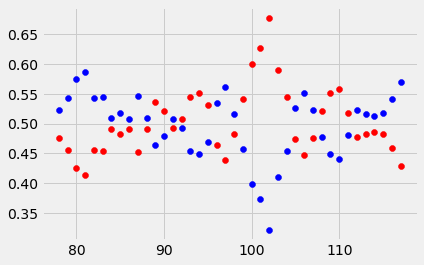

In [38]:
#Plots proportion of Senate that is Democrats and Republican over time
plt.scatter(reduced_senate_stats['congress'], reduced_senate_stats['prop_dem'], c='blue')
plt.scatter(reduced_senate_stats['congress'], reduced_senate_stats['prop_rep'], c='red')
plt.show()


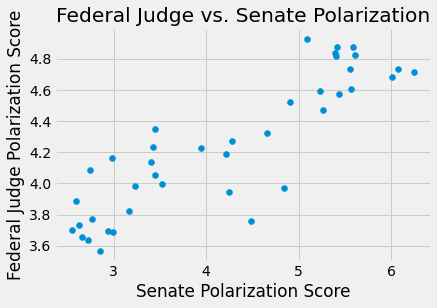

In [88]:
#Plots active federal judge polarization scores against Senate polarixation scores to visually explore the relationship
reduced_senate_stats = senate_stats_for_plot[senate_stats_for_plot['congress'] >= 78]
plt.scatter(reduced_senate_stats['polarization_score'], reduced_senate_stats['judge_polarization_score'])
plt.xlabel('Senate Polarization Score')
plt.ylabel('Federal Judge Polarization Score')
plt.title('Federal Judge vs. Senate Polarization')
plt.show()
    

In [100]:
#Defining some functions to run linear least-squares regression on the polarization score data and do bootstrap 
#significance testing
def regression_parameters(x,y):
    std_x = (x - np.mean(x))/np.std(x,ddof=1)
    std_y = (y - np.mean(y))/np.std(y,ddof=1)
    cov_xy = np.cov(x,y, ddof=1)[0][1]
    var_x = np.var(x,ddof=1)
    r = np.sum(std_x*std_y)/(len(std_x)-1)
    m = cov_xy / var_x
    b = np.average(y) - m * np.average(x)
    return np.array([r, b, m])

def MSE(x, y, m):
        e= np.sum( (( x-x.mean())* m + y.mean() - y)**2  ) / len(x)
        return(e)
    
def m_bootstrap_dist(x,y):
    m = regression_parameters(x,y)[2]
    m_dist = np.array([])
    for i in range(10000):
        sample = np.random.choice(np.arange(0,len(data)), size=len(data), replace=True)
        x_boot = [data[i][0] for i in sample]
        y_boot = [data[i][1] for i in sample]
        m_sample = regression_parameters(x_boot, y_boot)[2]
        m_dist = np.append(m_dist, m_sample)
    left_end = np.percentile(m_dist, 2.5)
    right_end = np.percentile(m_dist, 97.5)
    
    plt.hist(m_dist)
    plt.xlabel('Slopes')
    plt.show()
    return print('95% Confidence Interval for Slope: [' + str(left_end) + ', ' + str(right_end) + ']')
    
def fit(x_label, y_label, x, y):
    m = regression_parameters(x,y)[2]
    b = regression_parameters(x,y)[1]
    r = regression_parameters(x,y)[0]
    rangem = np.arange(-1, 1, 0.001)
    m_array = np.array([MSE(x, y, m) for m in rangem])
    
    plt.xlabel(x_label, size=20)
    plt.ylabel(y_label, size=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.title('Senate vs. Judge Polarization Scores', size=25)
    plt.plot(x, m*x + b, label='MSE', c='red')
    plt.scatter(x, y, label='Data')
    plt.legend(loc='best', prop={'size': 20})
    plt.show()
    
    plt.xlabel('Regression Slope', size=20)
    plt.ylabel('Mean Squared Error', size=20)
    plt.title('Regression Slope Error Function',size=25)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.plot(rangem, m_array)
    plt.show()
    
    data = list(zip(x,y)) 
    m_dist = np.array([])
    for i in range(10000):
        sample = np.random.choice(np.arange(0,len(data)), size=len(data), replace=True)
        x_boot = [data[i][0] for i in sample]
        y_boot = [data[i][1] for i in sample]
        m_sample = regression_parameters(x_boot, y_boot)[2]
        m_dist = np.append(m_dist, m_sample)
    left_end = np.percentile(m_dist, 2.5)
    right_end = np.percentile(m_dist, 97.5)
    
    plt.hist(m_dist, 150)
    
    plt.xlabel('Slopes', size=20)
    plt.ylabel('Count', size=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.title('Bootstrap Regression Slope Distribution',size=25)
    plt.show()
    
    print('Least Squares Regression Slope: ' + str(m))
    print('Least Squares Regression Intercept: ' + str(b))
    print('95% Confidence Interval for Slope: [' + str(left_end) + ', ' + str(right_end) + ']')
    

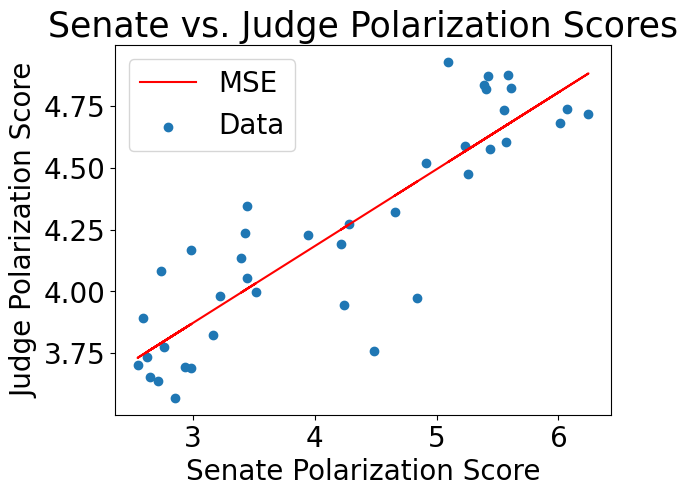

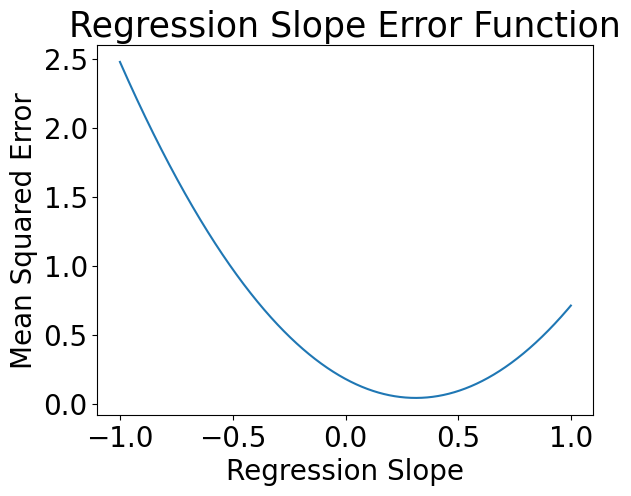

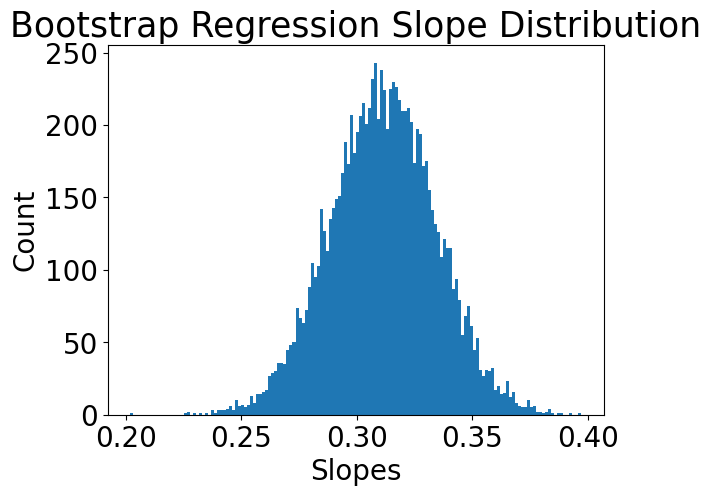

Least Squares Regression Slope: 0.31143557087875995
Least Squares Regression Intercept: 2.9376106072412824
95% Confidence Interval for Slope: [0.26609465863293563, 0.3562133784939897]


In [101]:
#running said linear regression and bootstrap significance testing
fit('Senate Polarization Score', 'Judge Polarization Score', reduced_senate_stats['polarization_score'],reduced_senate_stats['judge_polarization_score'])


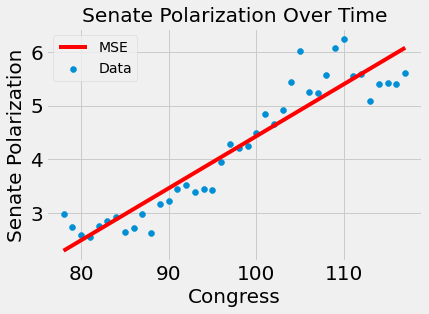

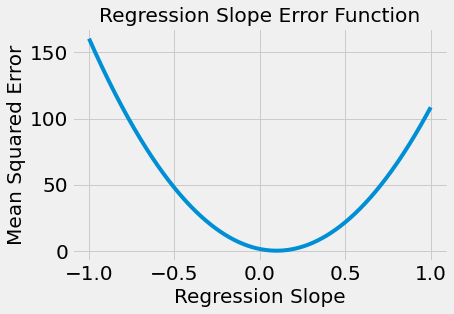

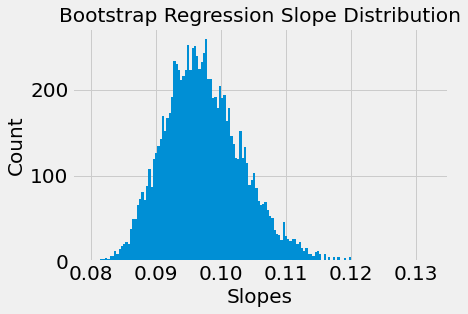

Least Squares Regression Slope: 0.09690101784841192
Least Squares Regression Intercept: -5.260795712120889
95% Confidence Interval for Slope: [0.0868173643812853, 0.11079803385893698]


In [97]:
fit('Congress', 'Senate Polarization', reduced_senate_stats['congress'],reduced_senate_stats['polarization_score'])


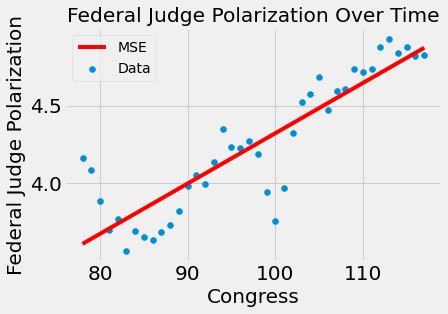

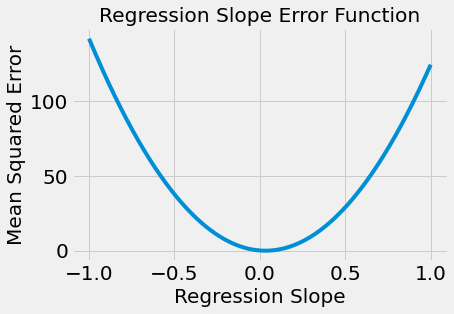

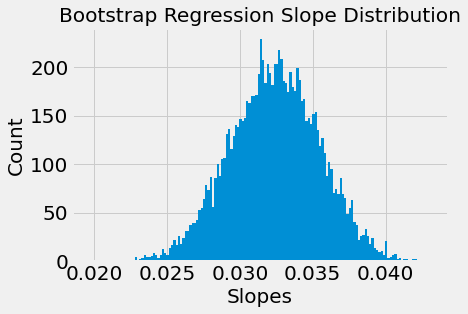

Least Squares Regression Slope: 0.03225043886208844
Least Squares Regression Intercept: 1.0971902240111824
95% Confidence Interval for Slope: [0.026337496068617478, 0.03835711990675061]


In [99]:
fit('Congress', 'Federal Judge Polarization', reduced_senate_stats['congress'],reduced_senate_stats['judge_polarization_score'])


In [ ]:
#Scraping and formatting current federal judge names 
current = pd.read_html('https://docs.google.com/spreadsheets/d/e/2PACX-1vTNz6D5qbUMC6diZ3bc2WfioYsGXRafKnr_qA9Wh2ggdVgK6vD5kEcH5UxNeiqxi-HiaCQnxDypAAyS/pubhtml/sheet?headers=false&gid=432843485', parse_dates=False)
current_apt = current[0]
current_apt.columns = current_apt.iloc[0]
current_apt = current_apt.drop(0, axis=0)
current_apt.reset_index(drop=True, inplace=True)
current_apt = current_apt.drop(['Appointing President', 'Party of Appointing President', 'Nomination Date', 'Service as Chief Judge, Begin', 'Service as Chief Judge, End', 'Senior Status Date', 'Court Type'], axis=1)
current_apt = current_apt.drop(1, axis=1)
current_apt.rename(columns={'Judge Name': 'judge_name', 'Court Name': 'post', 'Confirmation Date':'term_start'}, inplace=True)

judge_name = np.array([])
end_term = np.array([])
start_term = np.array([])
for i in range(len(current_apt)):
    name = current_apt['judge_name'].iloc[i]
    judge_name = np.append(judge_name, name_filter(name))
current_apt['judge_name'] = judge_name
current_apt['term_start'] = pd.to_datetime(current_apt['term_start'], errors='coerce')

term_ends = np.array([pd.to_datetime('2022', errors='coerce')])
term_ends = term_ends.repeat(len(current_apt))
current_apt['term_end'] = term_ends
current_apt
